# 1. Functions and imports

In [91]:
import os, sys, obspy
import numpy as np
import matplotlib.pyplot as plt
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libseisGT import inventory2traceid, get_FDSN_inventory, clean_trace, \
    attach_station_coordinates_from_inventory
from obspy.clients.fdsn import Client
#from obspy.core.util import AttribDict
from obspy.geodetics import locations2degrees, degrees2kilometers

    
def get_inventory_and_waveforms(fdsnClient, searchRadiusDeg, olat, olon, startt, endt, chanstring, data_root, overwrite=False):
    if not os.path.isdir(data_root):
        print('No such directory %s' % data_root)
        return None, None
    
    # STEP 1 - FIND STATIONS BY REQUESTING AN INVENTORY
    stationXmlFile = os.path.join(data_root, '%s_within_%.0f_degrees.xml' % (chanstring, searchRadiusDeg))
    mseedfile = stationXmlFile.replace('.xml','.mseed')
    print(stationXmlFile, mseedfile)
    
    if os.path.exists(stationXmlFile) and overwrite==False:
        inv = obspy.read_inventory(stationXmlFile)
    else:
        inv = get_FDSN_inventory(fdsnClient, startt, stationXmlFile, '*', olat, olon, \
            searchRadiusDeg, 0, endt - startt, channel = chanstring ) # get all low rate, outside barometers
    trace_ids = inventory2traceid(inv)
    print(trace_ids)
    
    # STEP 2 - LOAD CORRESPONDING WAVEFORM DATA
    if os.path.exists(mseedfile) and overwrite==False:
        st = obspy.core.read(mseedfile)
    else:
        st = obspy.core.Stream()
        for trace_id in trace_ids:
            try:
                net, sta, loc, cha = trace_id.split('.')
            except:
                net, sta, cha = trace_id.split('.')
                loc = '*'
            try:
                st0 = fdsnClient.get_waveforms(net, sta, loc, cha, startt, endt)
                print('waveform downloaded for ', trace_id)
                if len(st0)==1:
                    st.append(st0[0])
                else:
                    print('More than 1 Trace')
                    last_id = ''
                    for tr0 in st0:
                        if tr0.id != last_id:
                            st.append(tr0)
                        else:
                            st.remove(st[-1])
            except:
                print('failed to download waveform for ', trace_id)

        # save waveform data
        if len(st)>0:
            st.write(stationXmlFile.replace('.xml','.mseed'))
        
    return st, inv

def reconstitute_stream(st, inv, fmin=0.01):
    
    # deal with multiple traces with same trace ID, by appending and merging one at a time,
    # and removing any time there is a fail.
    st2 = obspy.core.Stream()
    for tr_original in st:
        tr = tr_original.copy()
        st2 = st2.append(tr)
        try:
            st2.merge(method=1, fill_value=0)
        except:
            st2.remove(tr)
            pass
        
    # reconstitute as many traces as possible, and return them
    reconstituted = obspy.core.Stream()
    failed_ids = []
    for tr_original in st2:
        tr = tr_original.copy()
        
        # remove gappy Trace objects, filled with 0 above (threshold 10%)
        n = np.count_nonzero(tr.data==0)
        if n/len(tr.data) > 0.1:
            st2.remove(tr_original)
            continue
            
        # high pass filter    
        tr.detrend('linear')
        tr.stats['maxamp_raw'] = np.max(np.abs(tr.data))
        tr.filter("highpass", freq=fmin)
        
        # remove response
        try:
            tr.remove_response(inventory=inv)
            reconstituted.append(tr)
            #print(tr.id, ' reconstituted')
        except:
            #print(tr.id, ' NOT reconstituted')
            failed_ids.append(tr.id)
            pass
        tr.detrend('linear')
        tr.stats['maxamp_corrected'] = np.max(np.abs(tr.data))
    print('Failed to reconstitute: ', failed_ids)

    #reconstituted.plot(equal_scale=True);
    
    return reconstituted


def attach_station_coordinates_from_inventory(inventory, st):
    """ attach_station_coordinates_from_inventory """
    for tr in st:
        for netw in inventory.networks:
            for sta in netw.stations:
                if tr.stats.station == sta.code and netw.code == tr.stats.network:
                    for cha in sta.channels:
                        if tr.stats.location == cha.location_code:
                            tr.stats.coordinates = obspy.core.util.AttribDict({
                                'latitude':cha.latitude,
                                'longitude':cha.longitude,
                                'elevation':cha.elevation})
                            
def attach_distance_to_stream(st, olat, olon):
    for tr in st:
        try:
            alat = tr.stats['coordinates']['latitude']
            alon = tr.stats['coordinates']['longitude']
            distdeg = locations2degrees(olat, olon, alat, alon)
            distkm = degrees2kilometers(distdeg)
            tr.stats['distance_in_km'] =  distkm
        except:
            print('cannot compute distance for %s' % tr.id)
            
def remove_outliers(a, f=100):
    m = np.median(a)
    bad_indices = []
    for i, v in enumerate(a):
        if v > m * f:
            bad_indices.append(i)
        if v * f < m:
            bad_indices.append(i)            
    #print(bad_indices)
    if len(bad_indices)>0:
        for i in bad_indices:
            a[i]=np.NaN 
    return a
    
def plot_amplitude_versus_distance(st, units):
    r = []
    a = []
    for tr in st:
        r.append(tr.stats.distance_in_km)
        #a.append(tr.stats.maxamp_corrected)
        a.append(np.max(np.abs(tr.data)))
    remove_outliers(a, f=10)     
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(r, a)
    ax.set_ylabel('Maximum amplitude (%s)' % units)
    ax.set_xlabel('Distance (km)')
    plt.show()
    
def plot_reduced_pressure(st, units):
    r = []
    a = []
    for tr in st:
        r.append(tr.stats.distance_in_km)
        #a.append(tr.stats.maxamp_corrected * np.sqrt(tr.stats.distance_in_km))
        a.append(np.max(np.abs(tr.data))* np.sqrt(tr.stats.distance_in_km))
    remove_outliers(a, f=10)    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(r, a)
    ax.set_ylabel('Reduced Pressure (%s)' % units)
    ax.set_xlabel('Distance (km)')
    plt.show()
    
def yes_or_no(question):
    while "the answer is invalid":
        reply = str(input(question+' (y/n): ')).lower().strip()
        if reply[:1] == 'y':
            return True
        if reply[:1] == 'n':
            return False
        
def manually_select_good_traces(st):
    stkeep = obspy.core.Stream()
    for tr in st:
        tr.plot()
        print('max = ', np.max(np.abs(tr.data)))
        if yes_or_no('keep this trace? '):
            stkeep.append(tr.copy())
    return stkeep

def select_previously_manually_selected_traces(st, good_ids):
    stkeep = obspy.core.Stream()
    for tr in st:
        if tr.id in good_ids:
            stkeep.append(tr.copy())
    return stkeep
            

# 2. Parameters

In [ ]:
fdsnClient = Client("IRIS")
DATA_ROOT = os.path.join(os.getenv('HOME'), 'DATA', 'Tonga202201')
searchRadiusDeg = 90.0

# location of Hunga-Tonga Hunga-Ha'apai
olat = -(20 + 34/60 + 12 /3600) 
olon = -(175 + 22/60 + 48/3600)
otime = obspy.core.UTCDateTime('2022-01-15T04:14:45.000000Z') # main eruption time - on day 2

startt = otime
endt = otime + 34 * 3600 # get 34 hours of data, since this is approximate time for sound waves to circle the earth

# 3. Run for infrasound channels

/Users/thompsong/DATA/Tonga202201/LDF_within_90_degrees.xml /Users/thompsong/DATA/Tonga202201/LDF_within_90_degrees.mseed
['AE.214A.LDF', 'AK.C16K.LDF', 'AK.C18K.LDF', 'AK.CAPN.LDF', 'AK.CHUM.LDF', 'AK.COLD.LDF', 'AK.CUT.LDF', 'AK.D17K.LDF', 'AK.E18K.LDF', 'AK.E19K.LDF', 'AK.F15K.LDF', 'AK.F18K.LDF', 'AK.F20K.LDF', 'AK.F21K.LDF', 'AK.G17K.LDF', 'AK.G19K.LDF', 'AK.G23K.LDF', 'AK.G24K.LDF', 'AK.H16K.LDF', 'AK.H17K.LDF', 'AK.H20K.LDF', 'AK.H21K.LDF', 'AK.H22K.LDF', 'AK.H23K.LDF', 'AK.H24K.LDF', 'AK.HARP.LDF', 'AK.HDA.LDF', 'AK.HOM.LDF', 'AK.I21K.LDF', 'AK.I23K.LDF', 'AK.I26K.LDF', 'AK.I27K.LDF', 'AK.J17K.LDF', 'AK.J19K.LDF', 'AK.J20K.LDF', 'AK.J25K.LDF', 'AK.J26L.LDF', 'AK.K13K.LDF', 'AK.K15K.LDF', 'AK.K20K.LDF', 'AK.K24K.LDF', 'AK.K27K.LDF', 'AK.L14K.LDF', 'AK.L16K.LDF', 'AK.L17K.LDF', 'AK.L18K.LDF', 'AK.L19K.LDF', 'AK.L20K.LDF', 'AK.L22K.LDF', 'AK.L26K.LDF', 'AK.M11K.LDF', 'AK.M14K.LDF', 'AK.M16K.LDF', 'AK.M19K.LDF', 'AK.M20K.LDF', 'AK.M23K.LDF', 'AK.M26K.LDF', 'AK.M27K.LDF', 'AK.MLY.LD

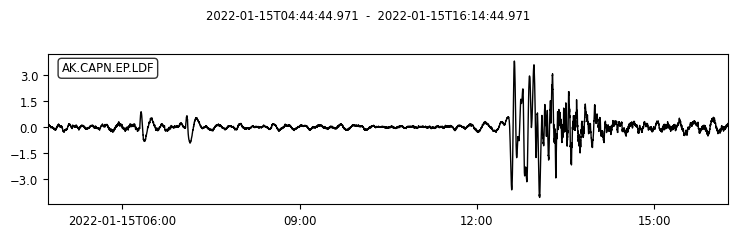

max =  4.0818810983
keep this trace?  (y/n): y


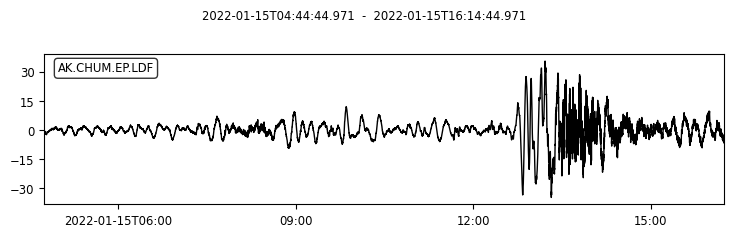

max =  35.4732425543
keep this trace?  (y/n): y


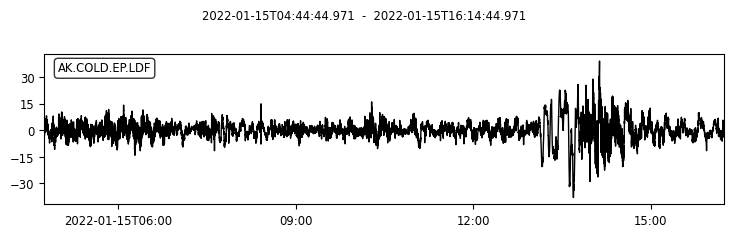

max =  38.979511404
keep this trace?  (y/n): y


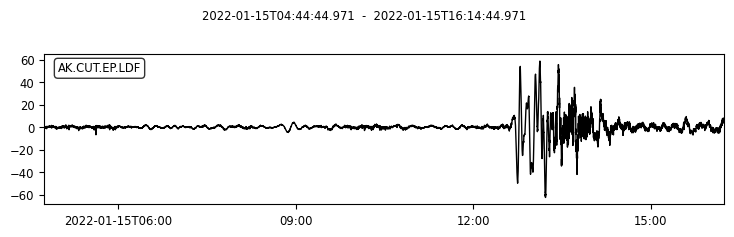

max =  62.5080205963
keep this trace?  (y/n): y


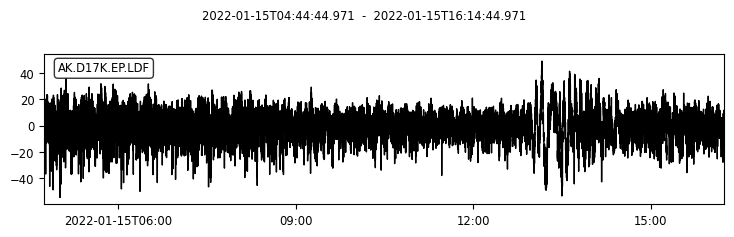

max =  54.5767993638
keep this trace?  (y/n): n


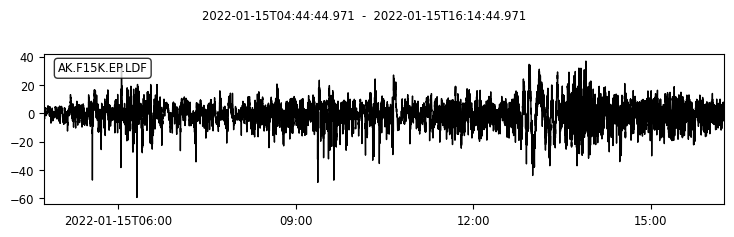

max =  59.4283261278
keep this trace?  (y/n): n


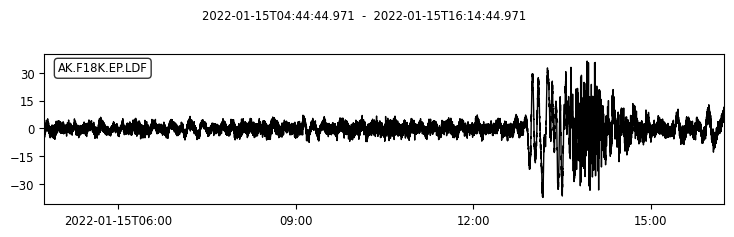

max =  37.3052487897
keep this trace?  (y/n): y


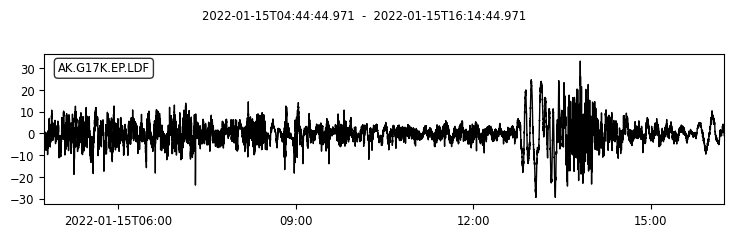

max =  33.2074919911
keep this trace?  (y/n): y


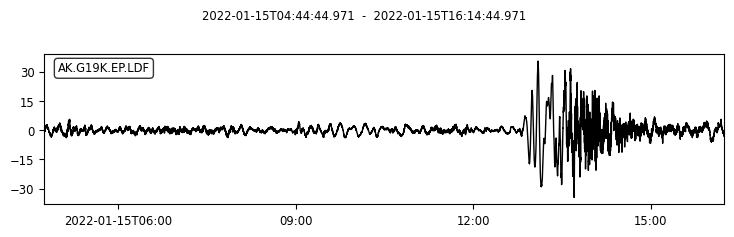

max =  35.4795353221
keep this trace?  (y/n): y


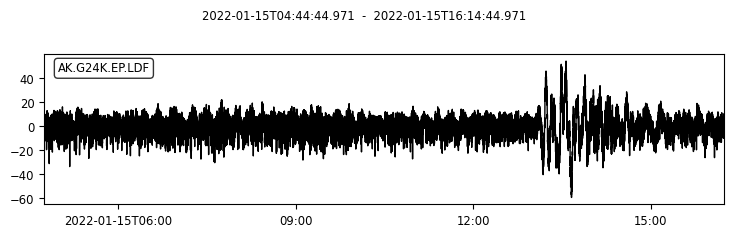

max =  59.1827155608
keep this trace?  (y/n): y


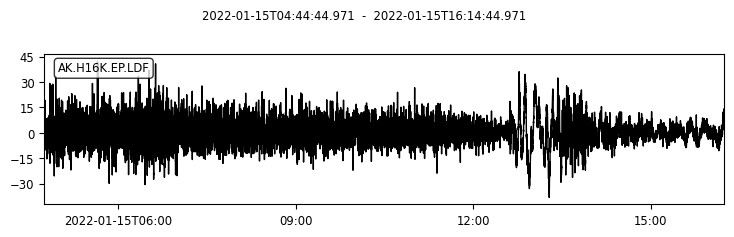

max =  42.3068048757
keep this trace?  (y/n): n


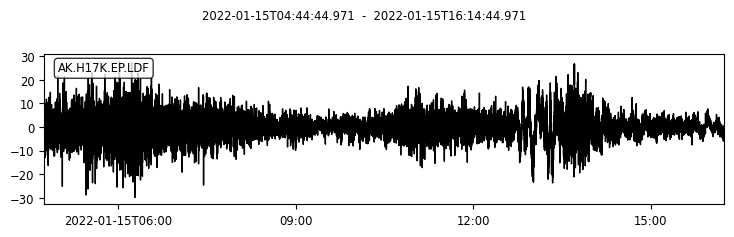

max =  29.7970901005
keep this trace?  (y/n): n


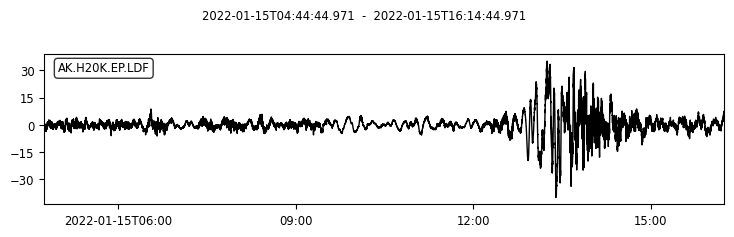

max =  39.9717856176
keep this trace?  (y/n): y


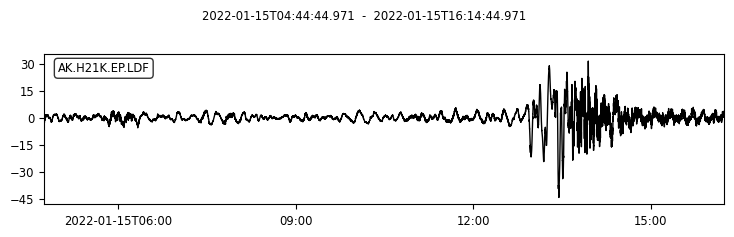

max =  44.3673081294
keep this trace?  (y/n): y


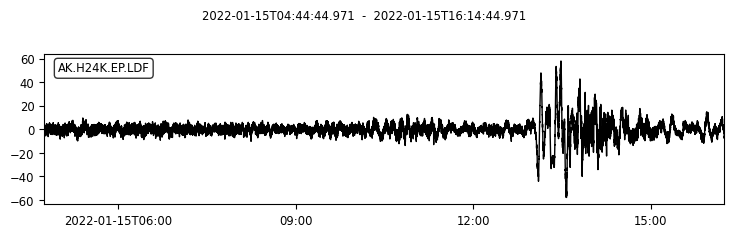

max =  57.9371259889
keep this trace?  (y/n): y


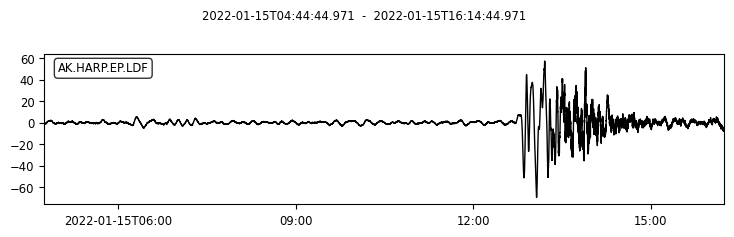

max =  69.4624634692
keep this trace?  (y/n): y


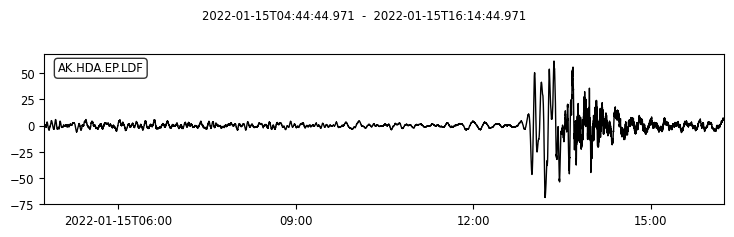

max =  68.6213989678
keep this trace?  (y/n): y


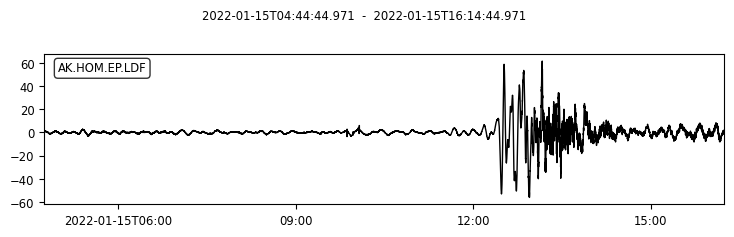

max =  61.4972617194
keep this trace?  (y/n): y


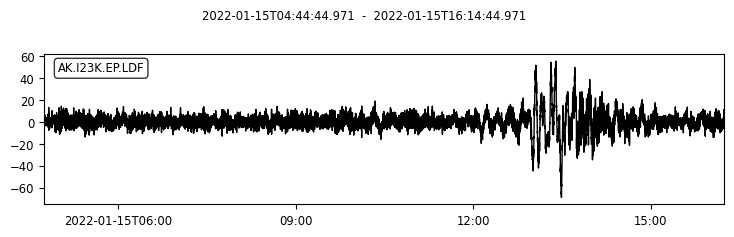

max =  68.9174351474
keep this trace?  (y/n): y


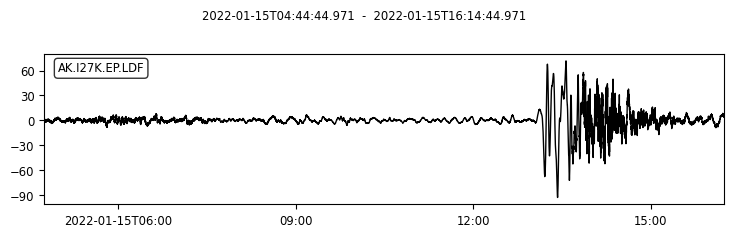

max =  93.0644466525
keep this trace?  (y/n): y


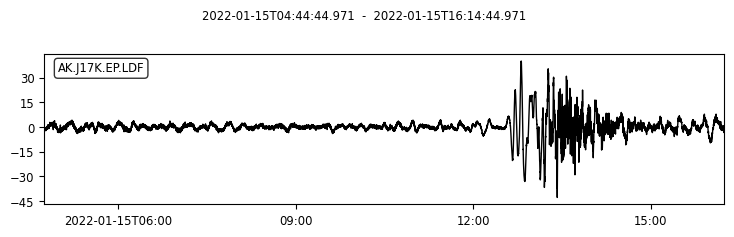

max =  42.8795625973
keep this trace?  (y/n): y


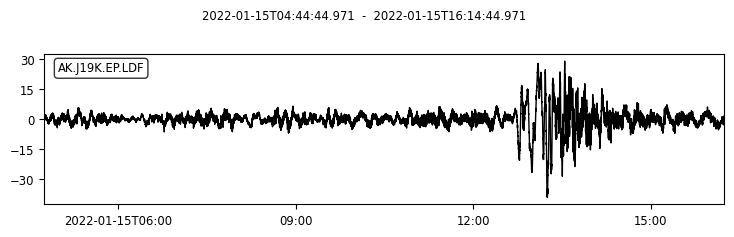

max =  39.2592958683
keep this trace?  (y/n): y


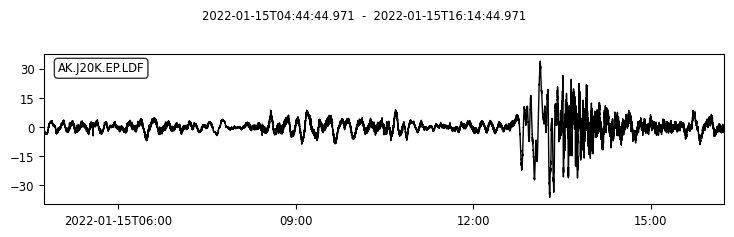

max =  36.1860404975
keep this trace?  (y/n): y


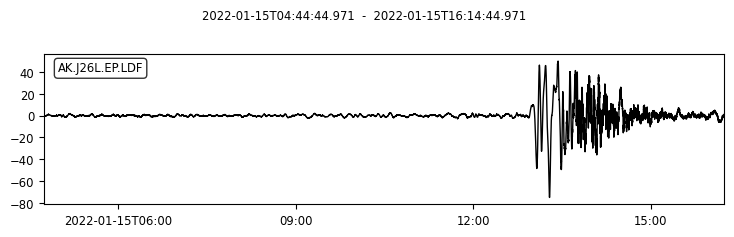

max =  75.059586992
keep this trace?  (y/n): y


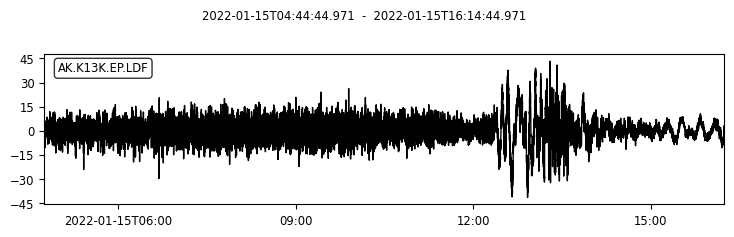

max =  43.3550007731
keep this trace?  (y/n): y


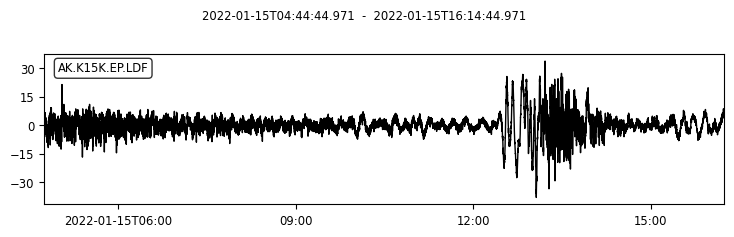

max =  38.1599257583
keep this trace?  (y/n): y


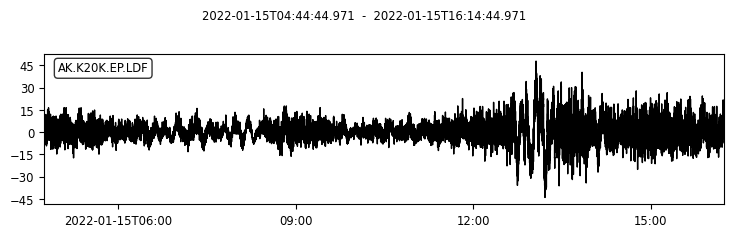

max =  47.9683166467
keep this trace?  (y/n): n


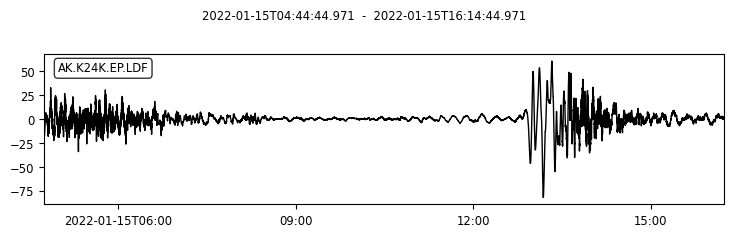

max =  82.0188057898
keep this trace?  (y/n): y


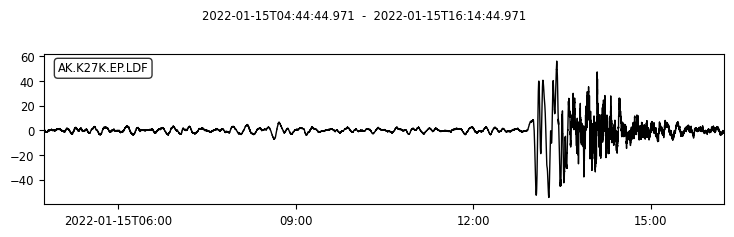

max =  56.1589987123
keep this trace?  (y/n): y


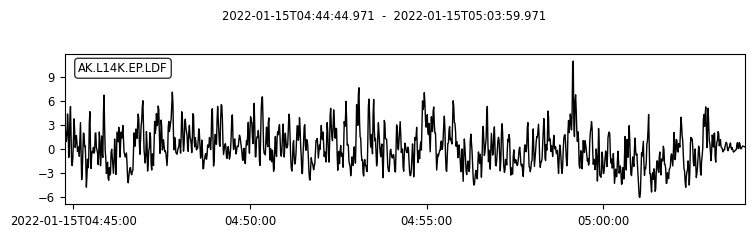

max =  10.9554109661
keep this trace?  (y/n): n


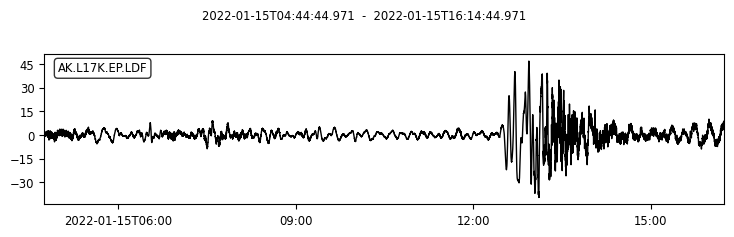

max =  46.8613510428
keep this trace?  (y/n): y


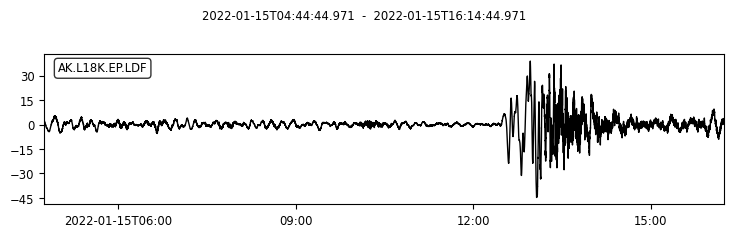

max =  44.7326871686
keep this trace?  (y/n): y


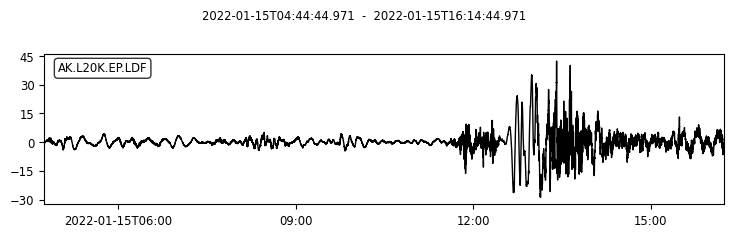

max =  42.2618252538
keep this trace?  (y/n): y


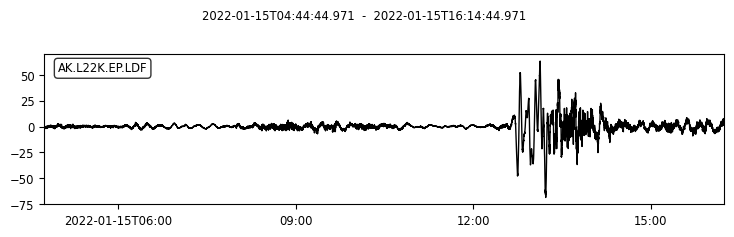

max =  68.8397783239
keep this trace?  (y/n): y


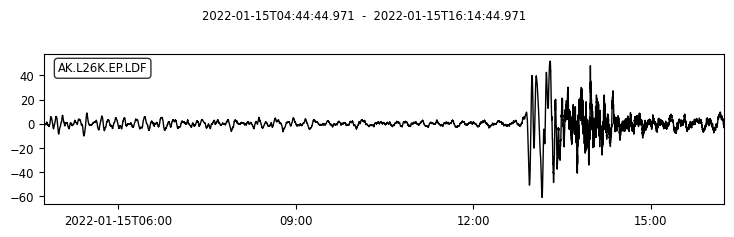

max =  60.9226349278
keep this trace?  (y/n): y


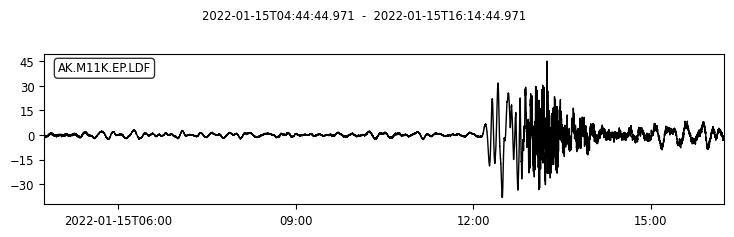

max =  45.1575712332
keep this trace?  (y/n): y


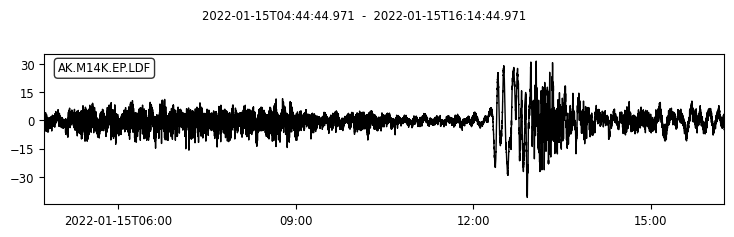

max =  40.974605002
keep this trace?  (y/n): y


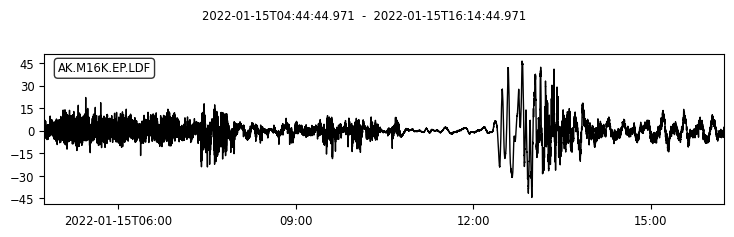

max =  46.2942327963
keep this trace?  (y/n): y


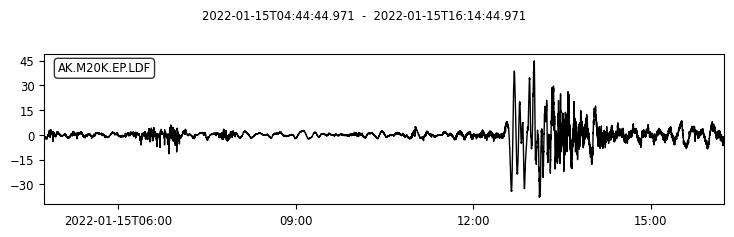

max =  44.7646877093
keep this trace?  (y/n): y


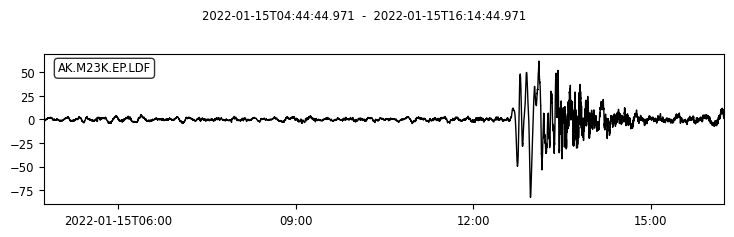

max =  82.5928876683
keep this trace?  (y/n): y


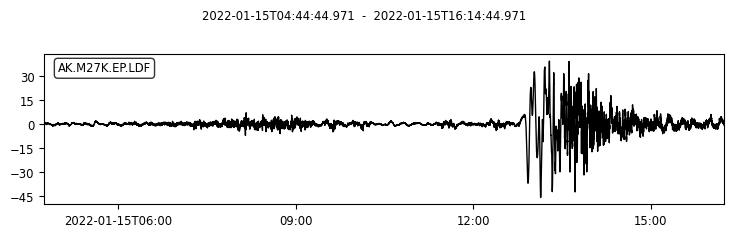

max =  45.924005325
keep this trace?  (y/n): y


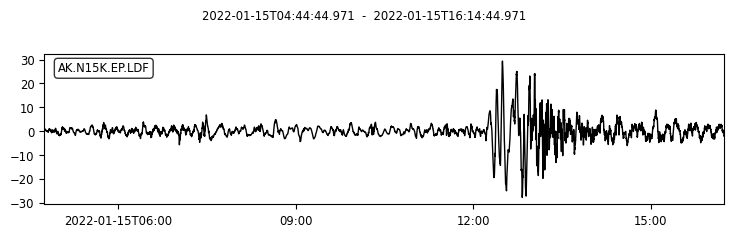

max =  29.3473875869
keep this trace?  (y/n): y


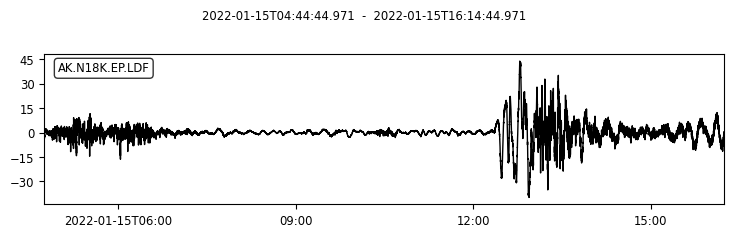

max =  43.9520315827
keep this trace?  (y/n): y


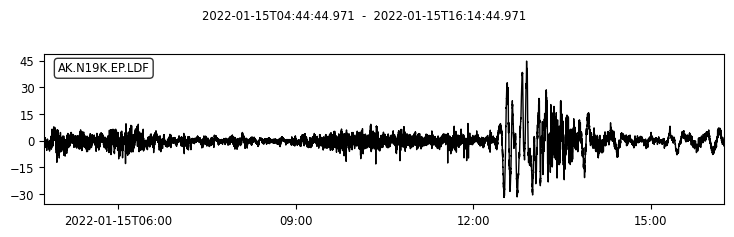

max =  44.7355968586
keep this trace?  (y/n): y


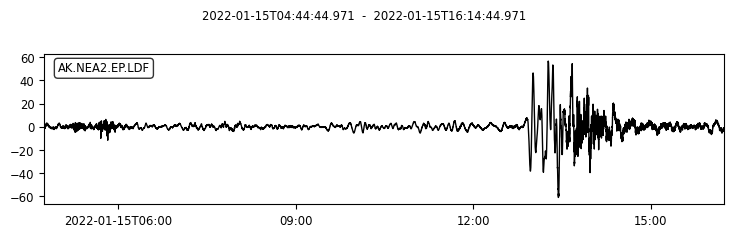

max =  60.8632509472
keep this trace?  (y/n): y


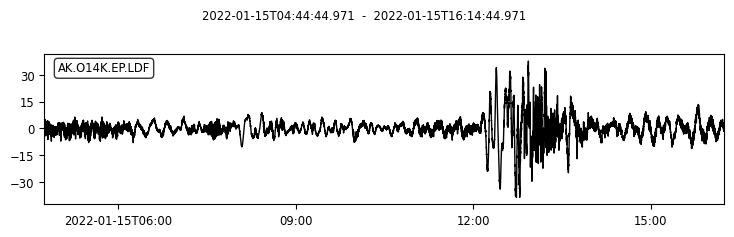

max =  38.7293049249
keep this trace?  (y/n): y


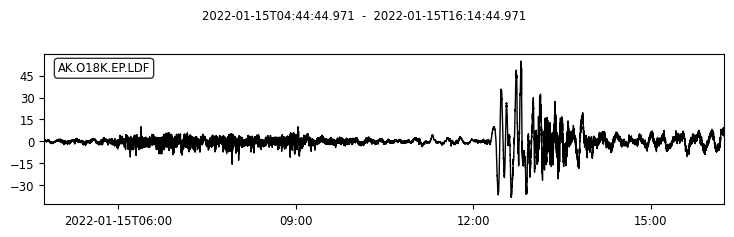

max =  55.053645626
keep this trace?  (y/n): y


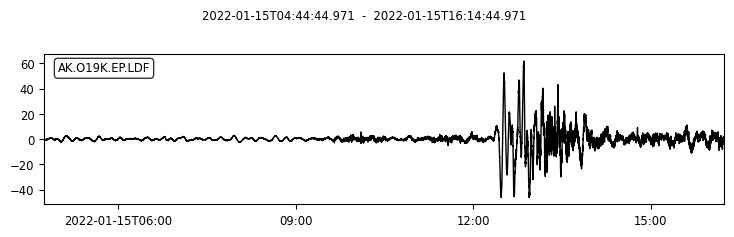

max =  61.7384155243
keep this trace?  (y/n): y


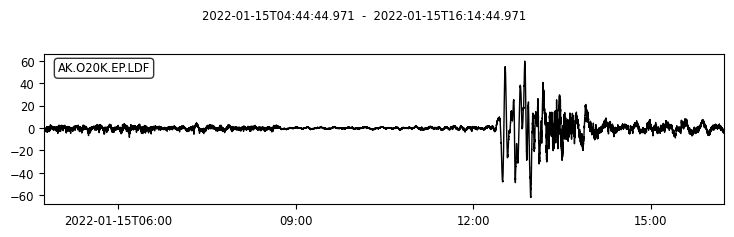

max =  62.0475558863
keep this trace?  (y/n): y


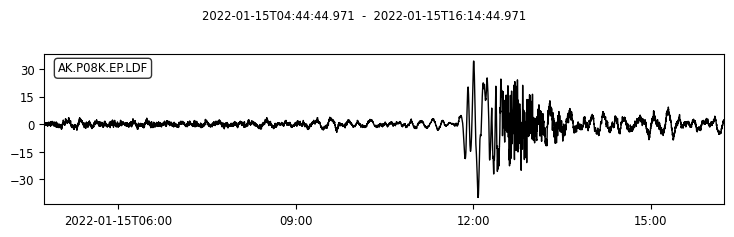

max =  39.8642240121
keep this trace?  (y/n): y


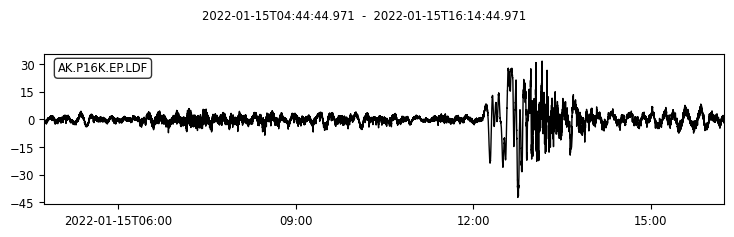

max =  42.3168761869
keep this trace?  (y/n): y


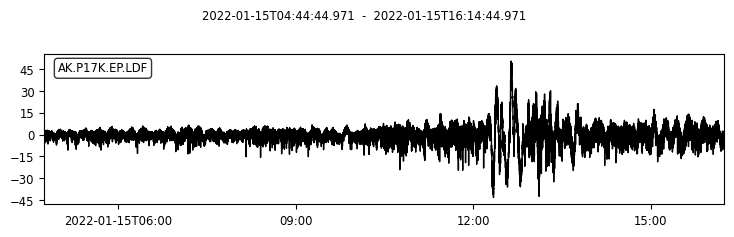

max =  50.4340807835
keep this trace?  (y/n): n


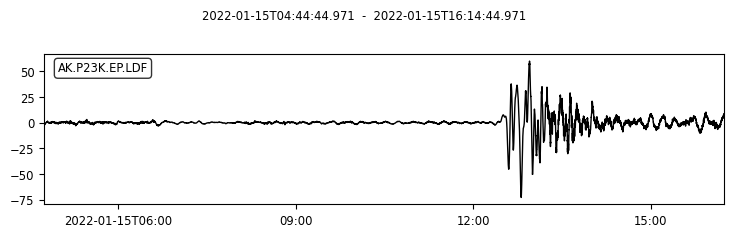

max =  72.8909117092
keep this trace?  (y/n): y


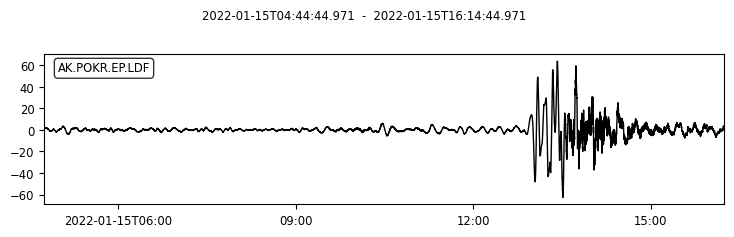

max =  63.8362319982
keep this trace?  (y/n): y


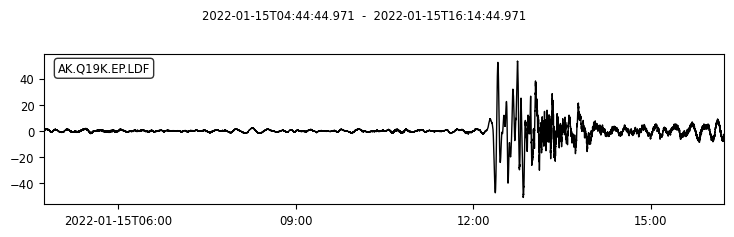

max =  53.4483741046
keep this trace?  (y/n): y


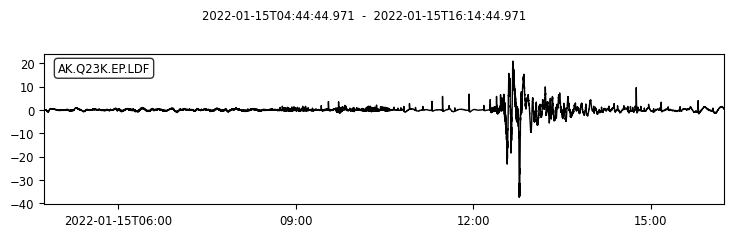

max =  37.4577062181
keep this trace?  (y/n): n


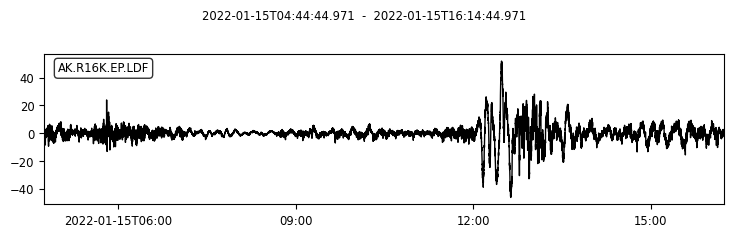

max =  51.905154438
keep this trace?  (y/n): y


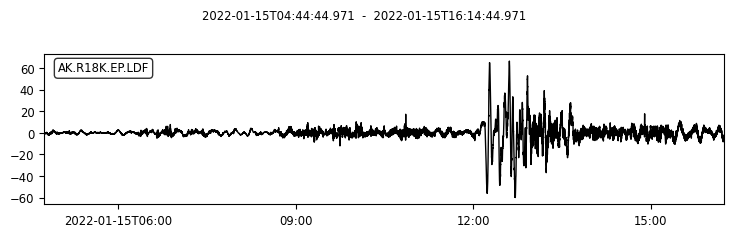

max =  66.5351519989
keep this trace?  (y/n): y


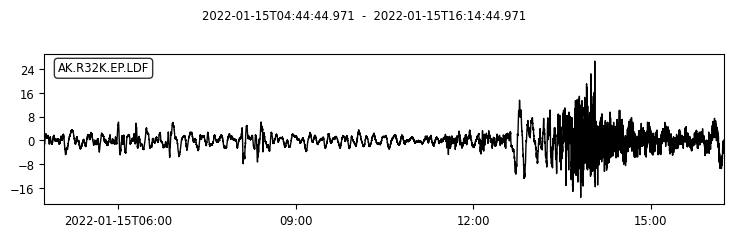

max =  26.6654255962
keep this trace?  (y/n): n


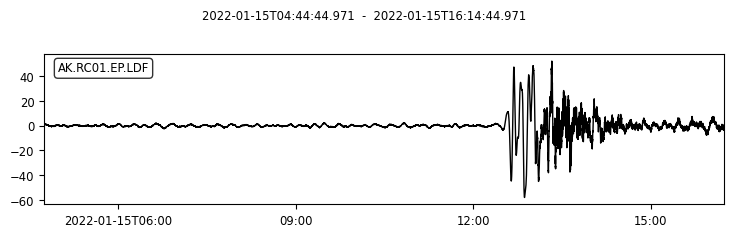

max =  58.1098159063
keep this trace?  (y/n): y


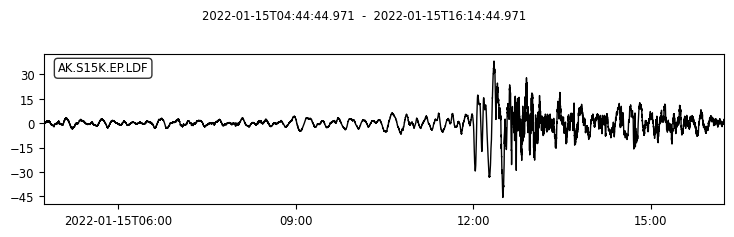

max =  45.6846536873
keep this trace?  (y/n): y


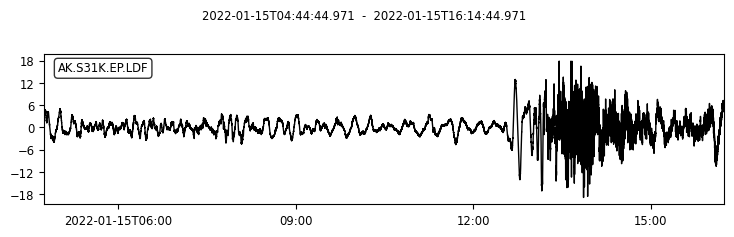

max =  18.8723665836
keep this trace?  (y/n): y


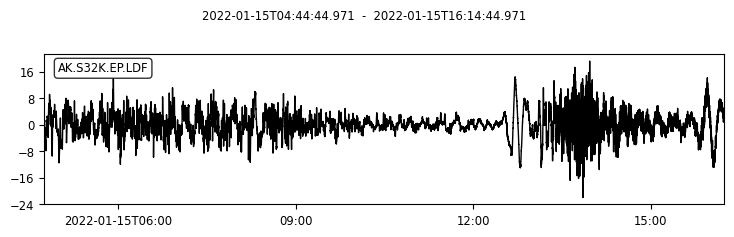

max =  21.9759833365
keep this trace?  (y/n): n


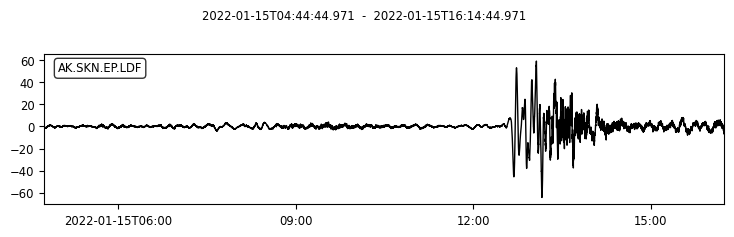

max =  64.3453042356
keep this trace?  (y/n): y


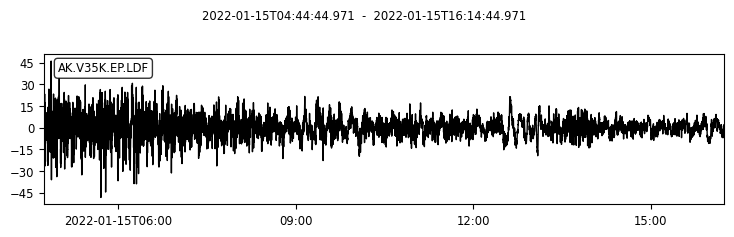

max =  48.407615301
keep this trace?  (y/n): n


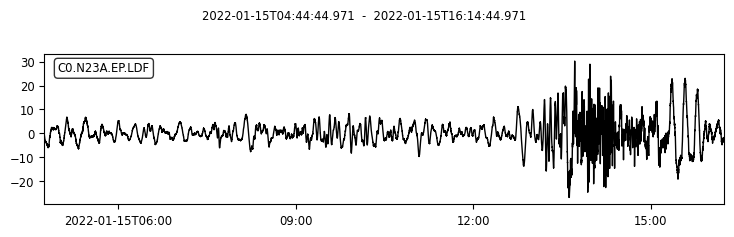

max =  30.2520997201
keep this trace?  (y/n): y


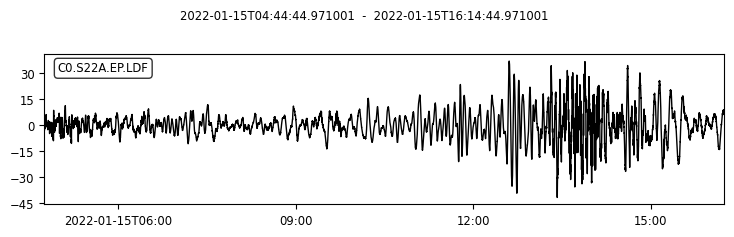

max =  41.5967527778
keep this trace?  (y/n): n


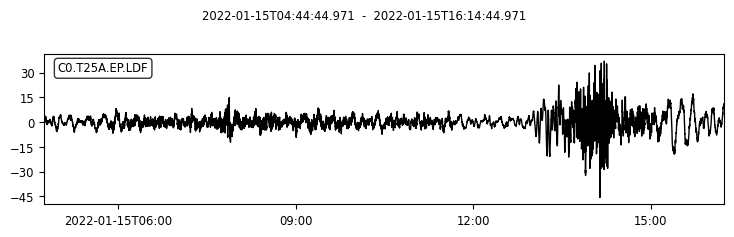

max =  45.7072724928
keep this trace?  (y/n): y


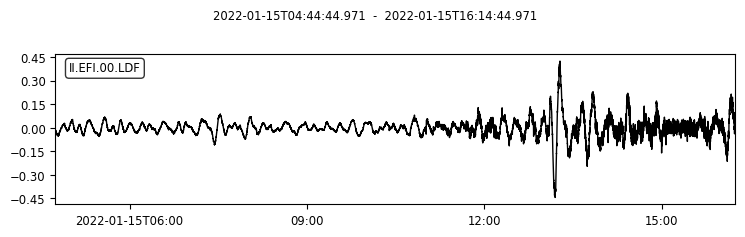

max =  0.443917942289
keep this trace?  (y/n): n


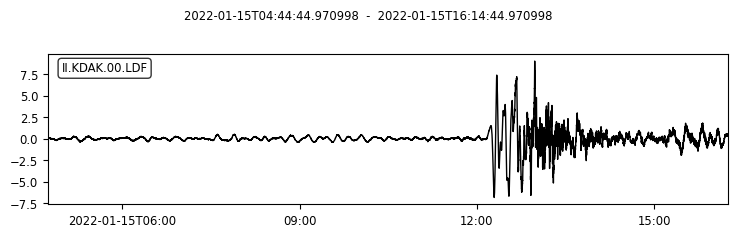

max =  9.01389070043
keep this trace?  (y/n): y


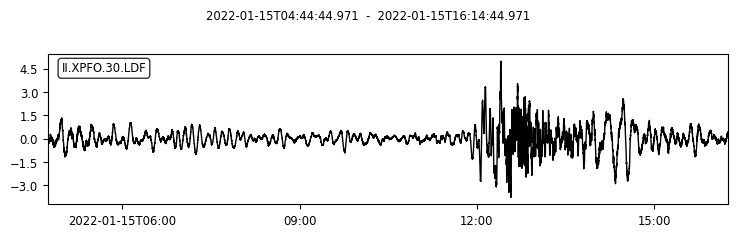

max =  4.98074914449
keep this trace?  (y/n): y


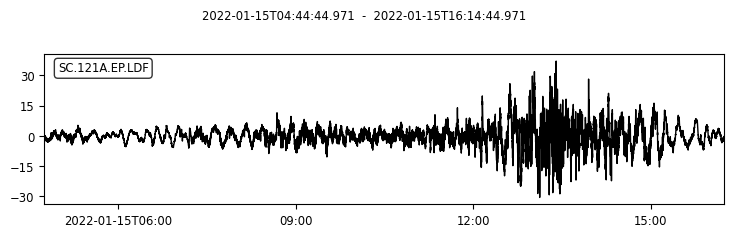

max =  37.072863816
keep this trace?  (y/n): y


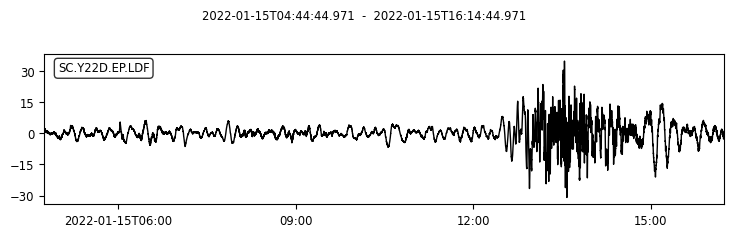

max =  34.8272019395
keep this trace?  (y/n): y


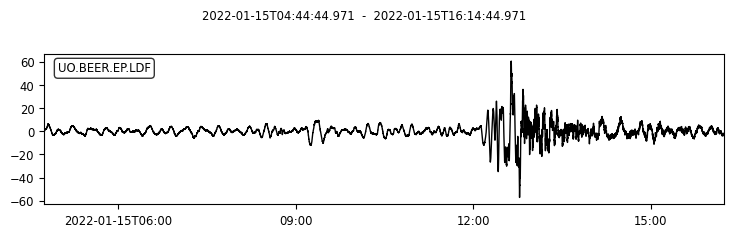

max =  60.5803623185
keep this trace?  (y/n): y


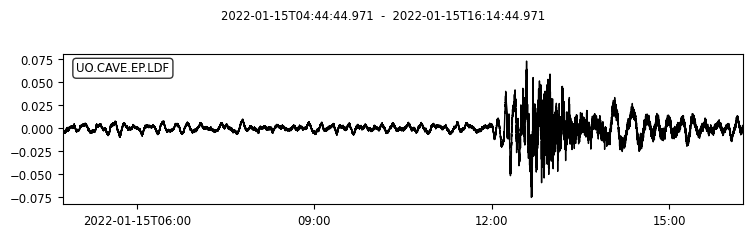

max =  0.0751607443618
keep this trace?  (y/n): n


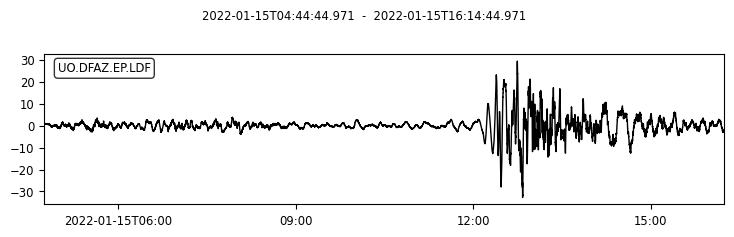

max =  32.7229617288
keep this trace?  (y/n): y


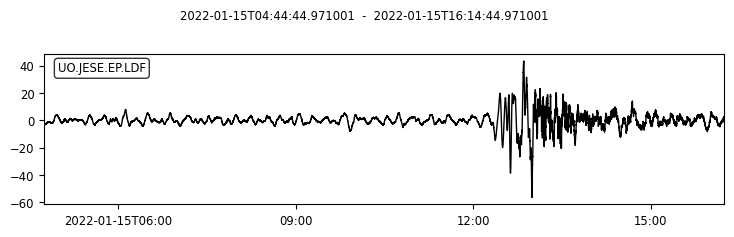

max =  56.4856795347
keep this trace?  (y/n): y


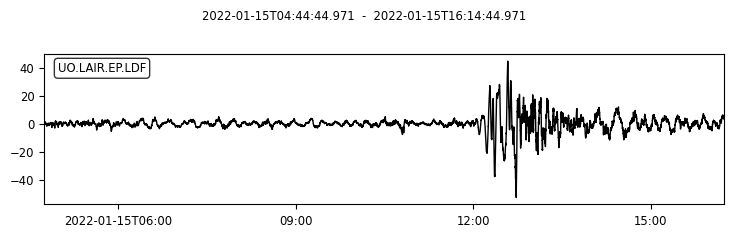

max =  52.6938615934
keep this trace?  (y/n): y


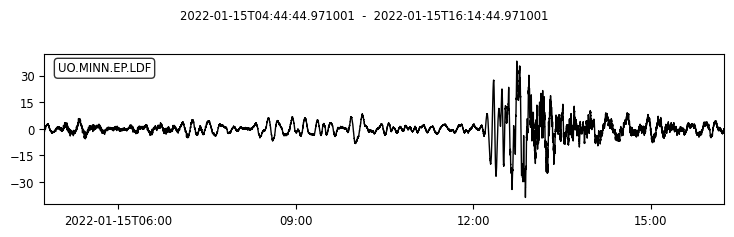

max =  38.7314320458
keep this trace?  (y/n): y


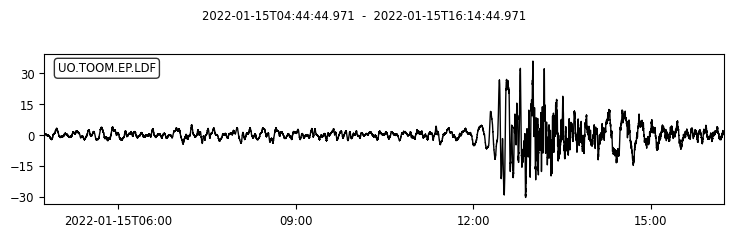

max =  35.7224907209
keep this trace?  (y/n): y


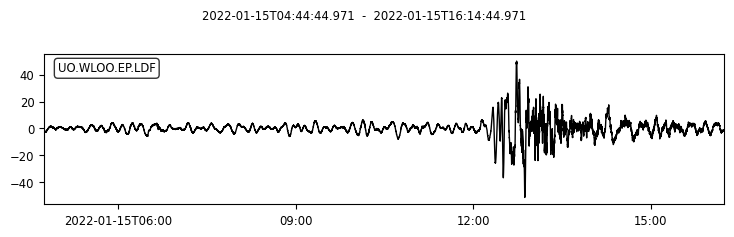

max =  51.6685741472
keep this trace?  (y/n): y


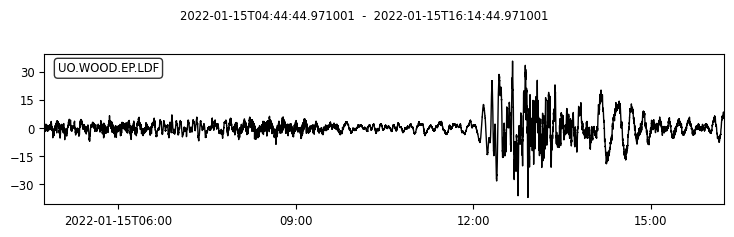

max =  37.1775478324
keep this trace?  (y/n): y


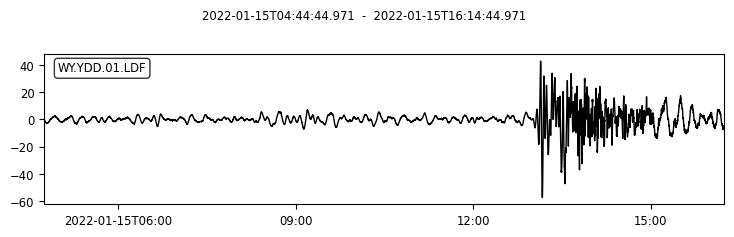

max =  57.2760805207
keep this trace?  (y/n): y


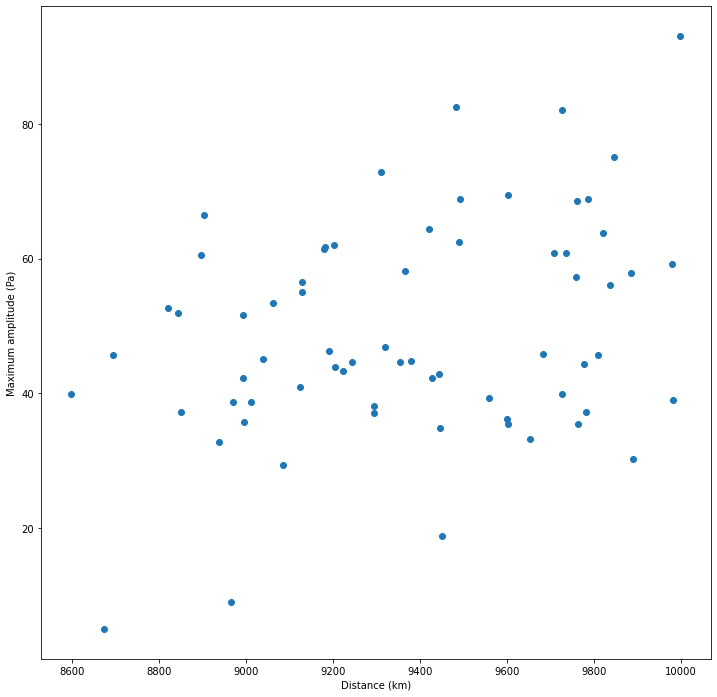

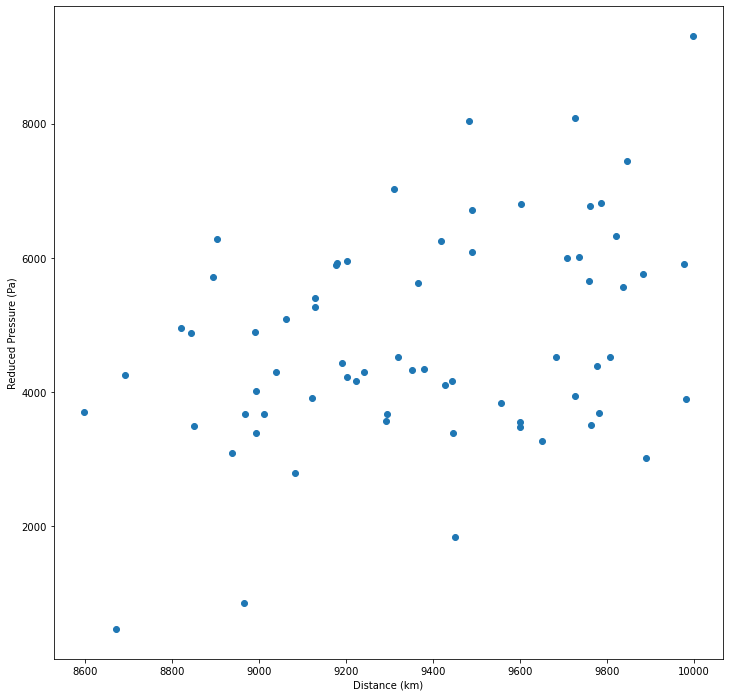

In [94]:
chanstring = 'LDF'
ldf_stream, ldf_inventory = get_inventory_and_waveforms(fdsnClient, searchRadiusDeg, olat, olon, startt, endt, chanstring, DATA_ROOT, overwrite=False)
ldf_reconstituted = reconstitute_stream(ldf_stream, ldf_inventory, fmin=0.001)
ldf_reconstituted.trim(starttime=startt+30*60, endtime=startt+12*3600)
ldf_good = manually_select_good_traces(ldf_reconstituted)
#ldf_good = select_previously_manually_selected_traces(ldf_reconstituted, good_ids)

attach_station_coordinates_from_inventory(ldf_inventory, ldf_good)
attach_distance_to_stream(ldf_good, olat, olon)
plot_amplitude_versus_distance(ldf_good, 'Pa')
plot_reduced_pressure(ldf_good, 'Pa')


# 4. Run for barometers outside (LDO)

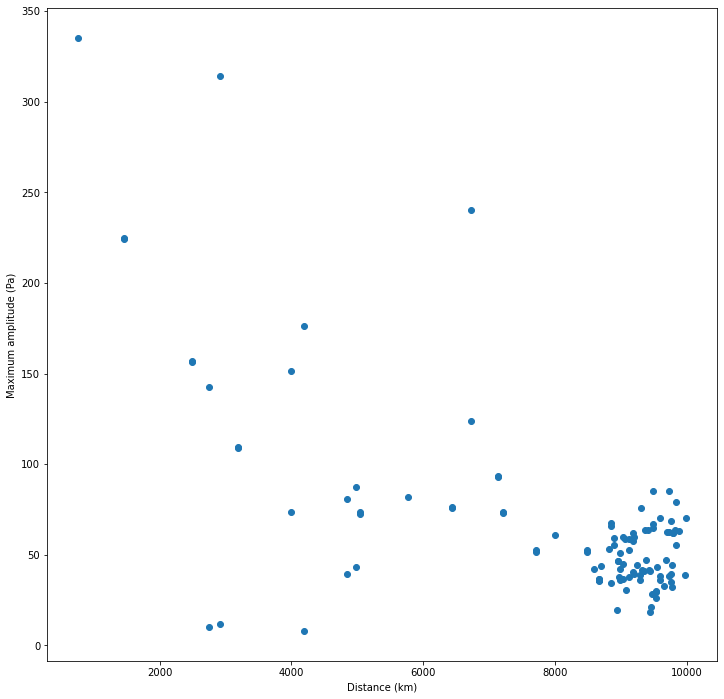

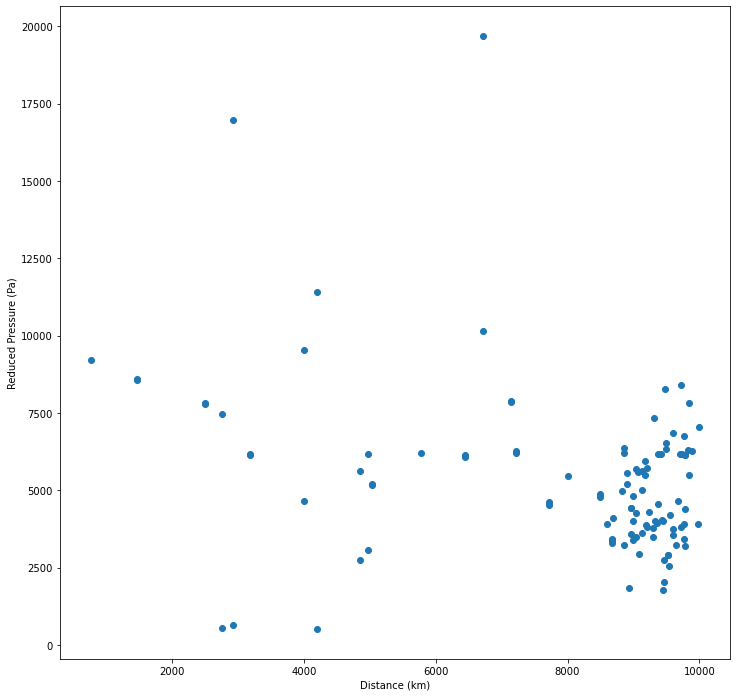

In [92]:
chanstring = 'LDO'
ldo_stream, ldo_inventory = get_inventory_and_waveforms(fdsnClient, searchRadiusDeg, \
            olat, olon, startt, endt, chanstring, DATA_ROOT, overwrite=False)

ldo_reconstituted = reconstitute_stream(ldo_stream, ldo_inventory, fmin=0.001)
ldo_reconstituted.trim(starttime=startt+30*60, endtime=startt+12*3600)
#ldo_good = manually_select_good_traces(ldo_reconstituted)
ldo_good = select_previously_manually_selected_traces(ldo_reconstituted, good_ids)
attach_station_coordinates_from_inventory(ldo_inventory, ldo_good)
attach_distance_to_stream(ldo_good, olat, olon)

plot_amplitude_versus_distance(ldo_good, 'Pa')
plot_reduced_pressure(ldo_good, 'Pa')

In [85]:
good_ids = []
for tr in ldo_good:
    good_ids.append(tr.id)
print(good_ids)

['AK.CHUM.EP.LDO', 'AK.COLD.EP.LDO', 'AK.CUT.EP.LDO', 'AK.F18K.EP.LDO', 'AK.G17K.EP.LDO', 'AK.G19K.EP.LDO', 'AK.H20K.EP.LDO', 'AK.H21K.EP.LDO', 'AK.H24K.EP.LDO', 'AK.HARP.EP.LDO', 'AK.HDA.EP.LDO', 'AK.HOM.EP.LDO', 'AK.I27K.EP.LDO', 'AK.J17K.EP.LDO', 'AK.J19K.EP.LDO', 'AK.J20K.EP.LDO', 'AK.J26L.EP.LDO', 'AK.K15K.EP.LDO', 'AK.K24K.EP.LDO', 'AK.K27K.EP.LDO', 'AK.L17K.EP.LDO', 'AK.L18K.EP.LDO', 'AK.L20K.EP.LDO', 'AK.L22K.EP.LDO', 'AK.L26K.EP.LDO', 'AK.M11K.EP.LDO', 'AK.M14K.EP.LDO', 'AK.M16K.EP.LDO', 'AK.M20K.EP.LDO', 'AK.M23K.EP.LDO', 'AK.M27K.EP.LDO', 'AK.N15K.EP.LDO', 'AK.N18K.EP.LDO', 'AK.N19K.EP.LDO', 'AK.NEA2.EP.LDO', 'AK.O14K.EP.LDO', 'AK.O18K.EP.LDO', 'AK.O19K.EP.LDO', 'AK.O20K.EP.LDO', 'AK.P08K.EP.LDO', 'AK.P16K.EP.LDO', 'AK.P23K.EP.LDO', 'AK.POKR.EP.LDO', 'AK.Q19K.EP.LDO', 'AK.R32K.EP.LDO', 'AK.RC01.EP.LDO', 'AK.S15K.EP.LDO', 'AK.S31K.EP.LDO', 'AK.S32K.EP.LDO', 'AK.SKN.EP.LDO', 'II.MSVF.00.LDO', 'IU.ANMO.30.LDO', 'IU.ANMO.31.LDO', 'IU.CASY.30.LDO', 'IU.CASY.31.LDO', 'IU.COLA.30.L

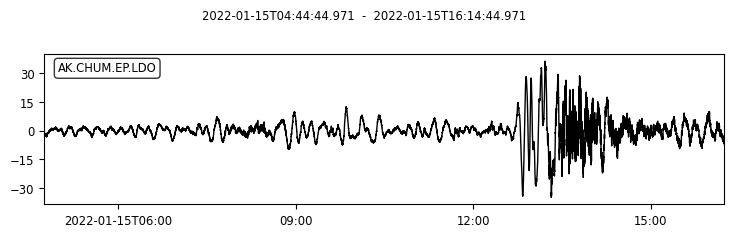

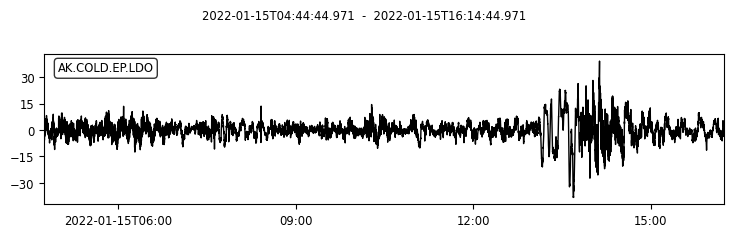

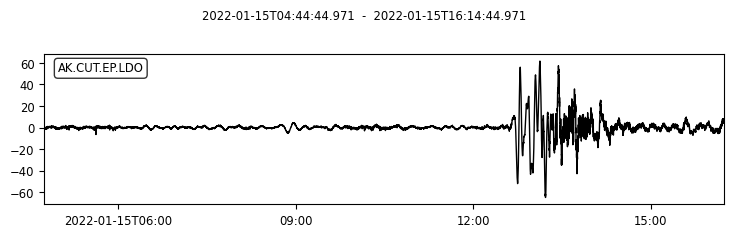

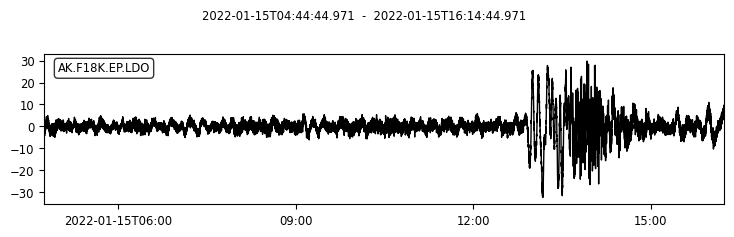

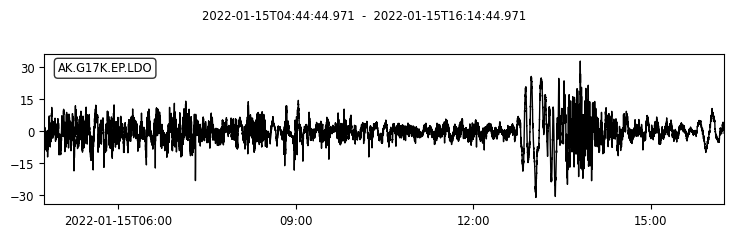

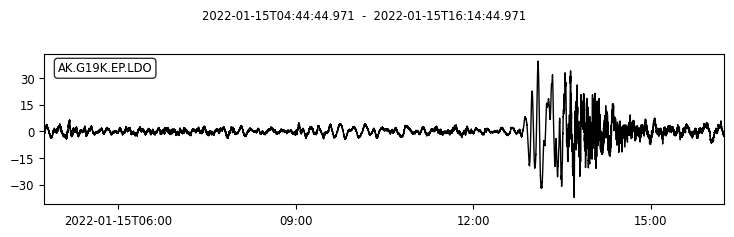

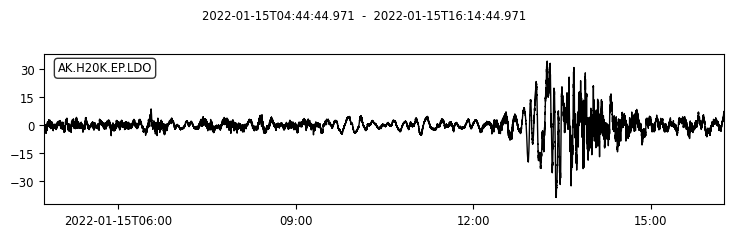

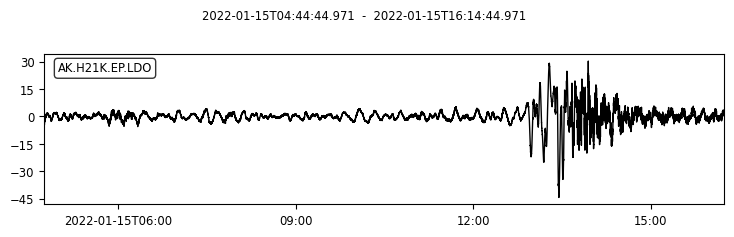

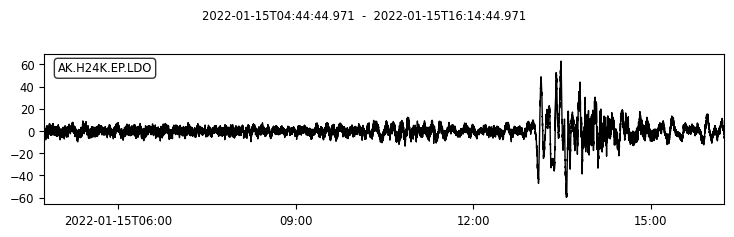

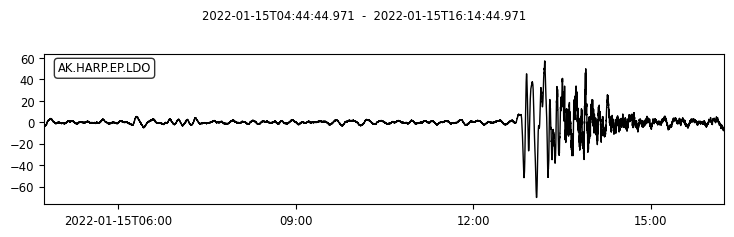

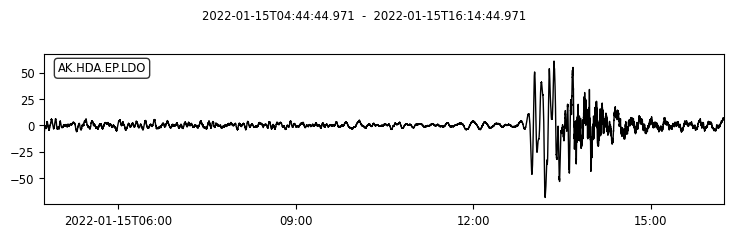

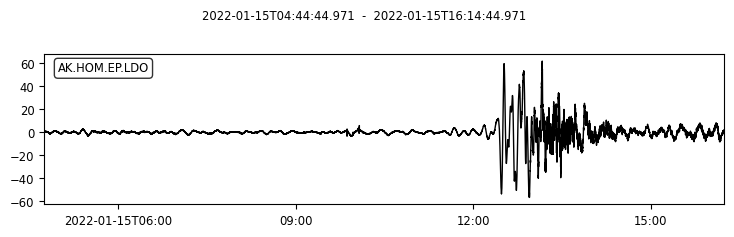

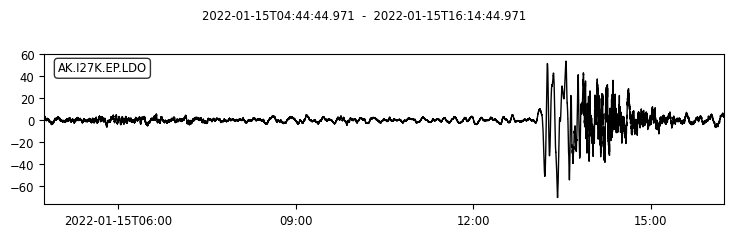

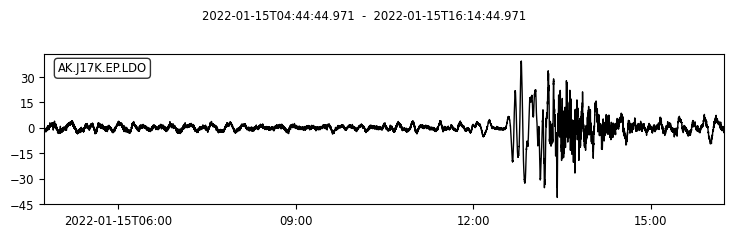

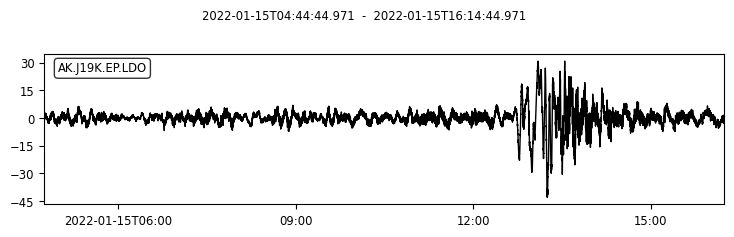

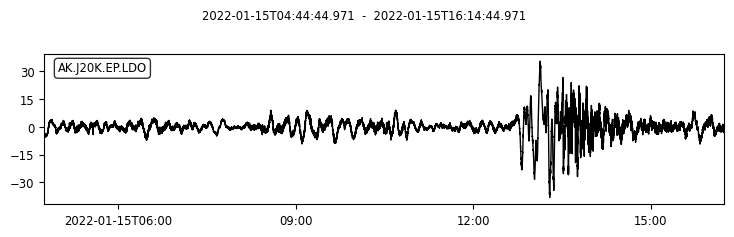

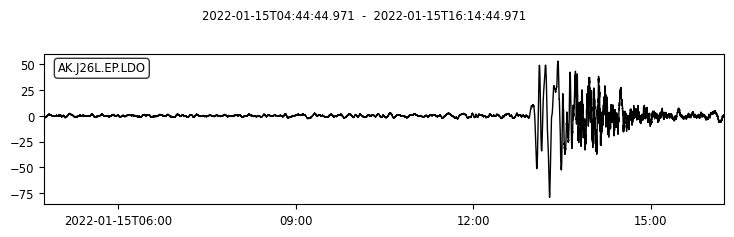

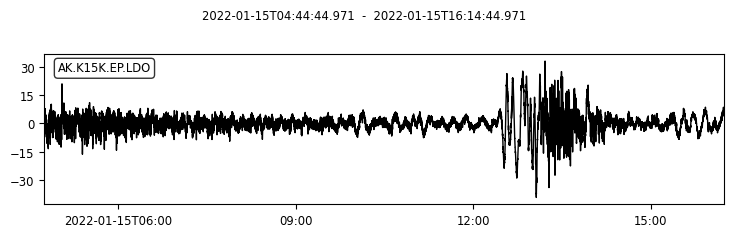

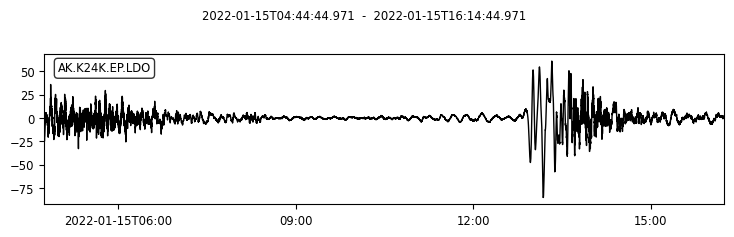

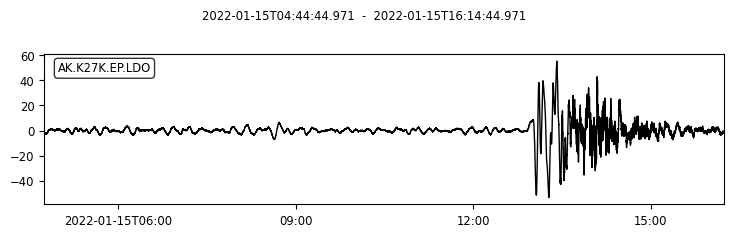

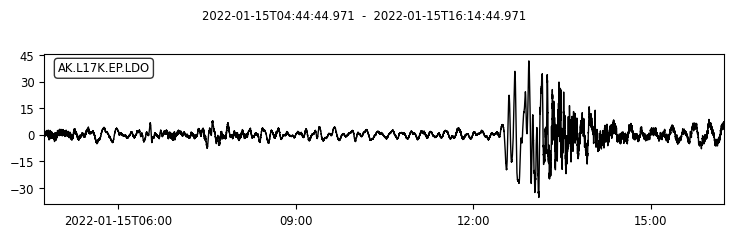

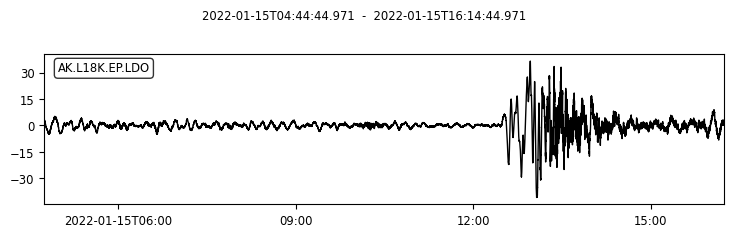

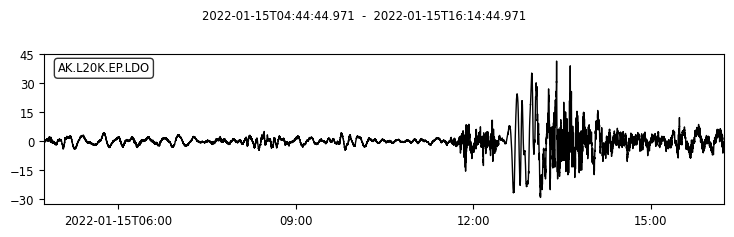

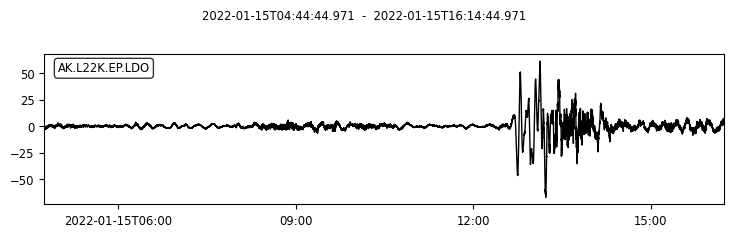

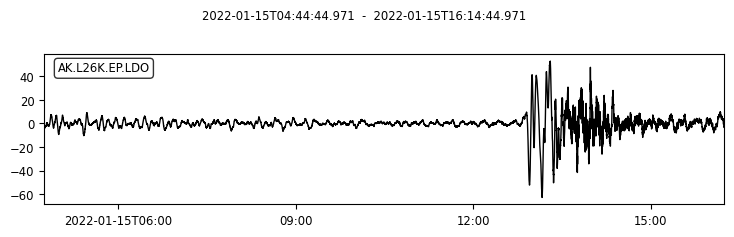

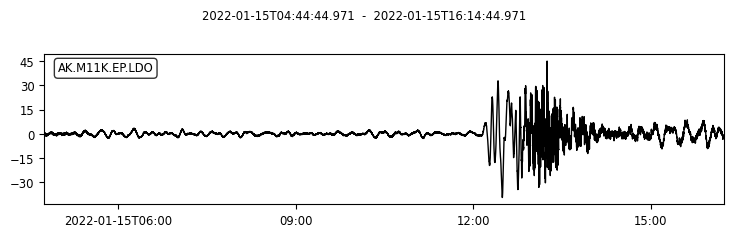

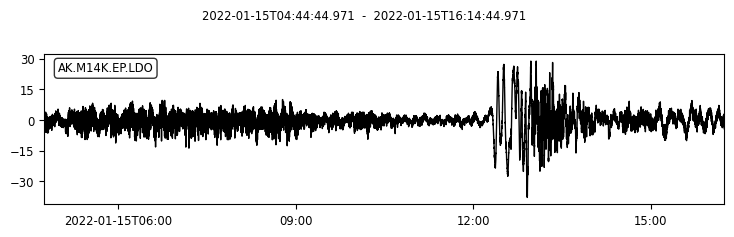

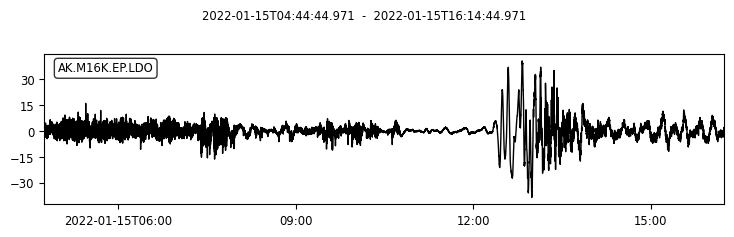

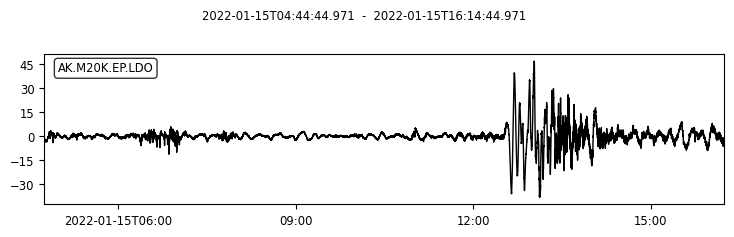

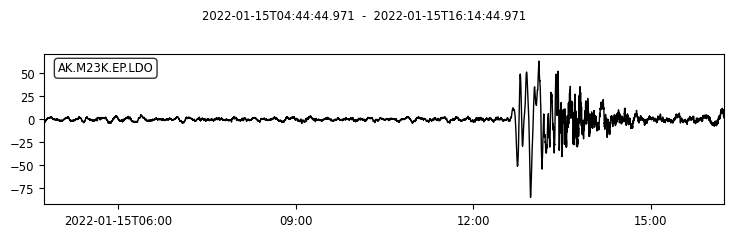

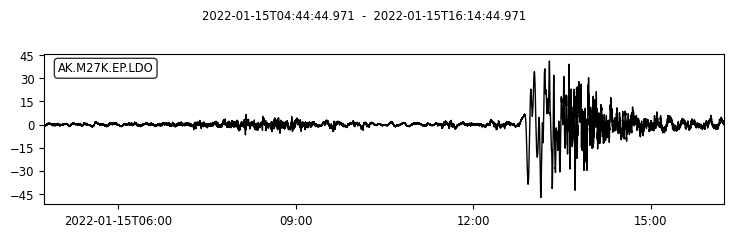

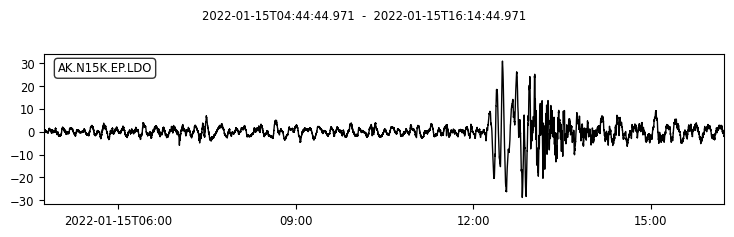

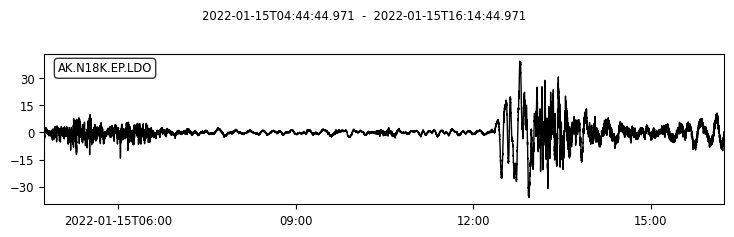

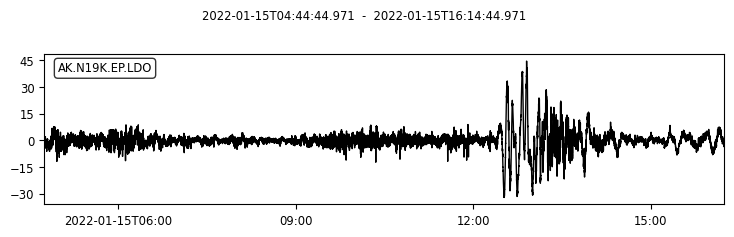

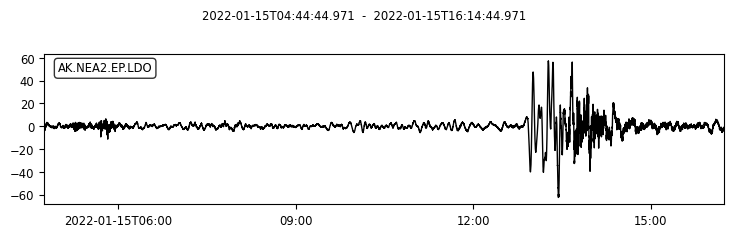

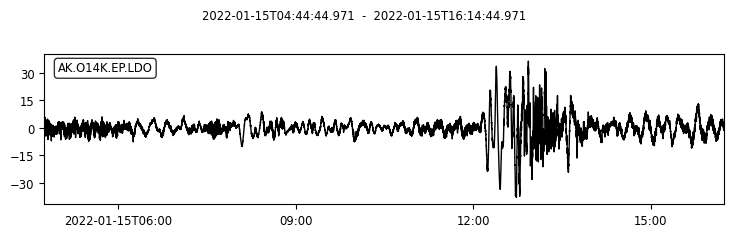

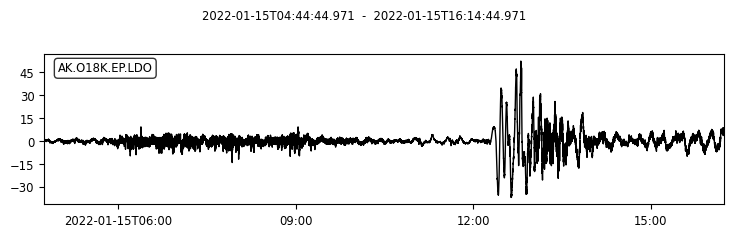

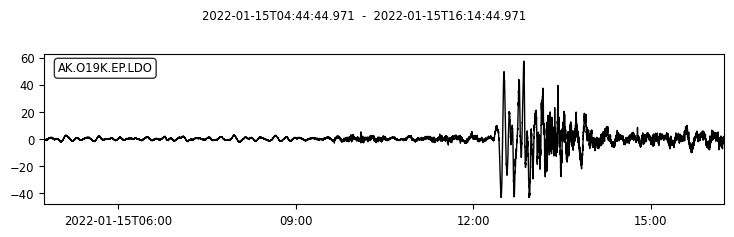

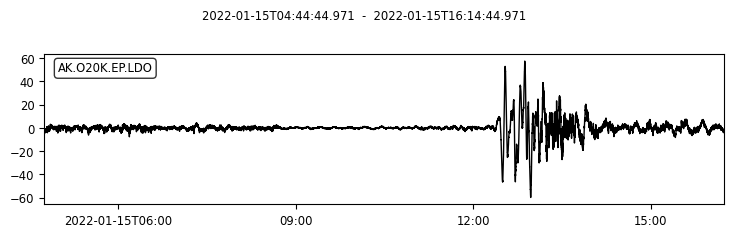

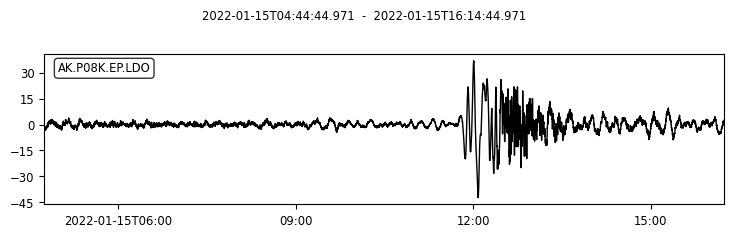

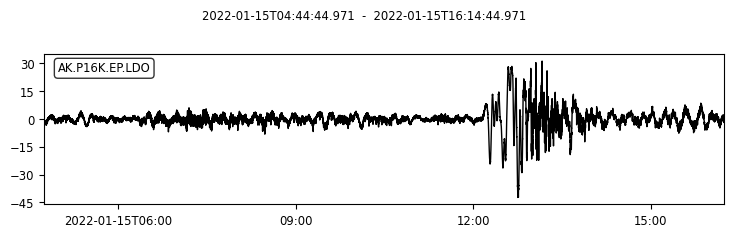

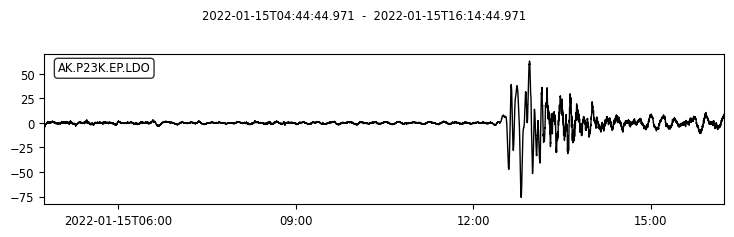

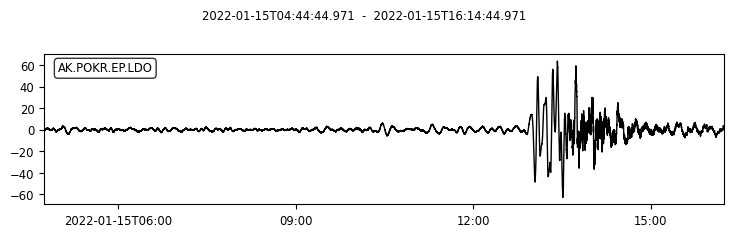

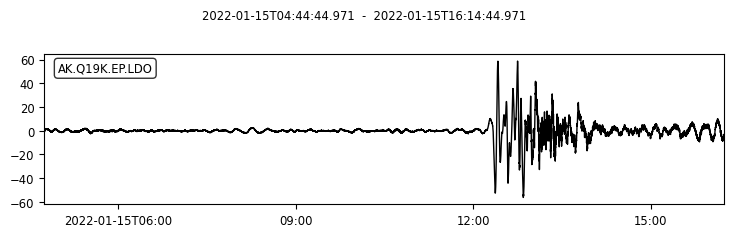

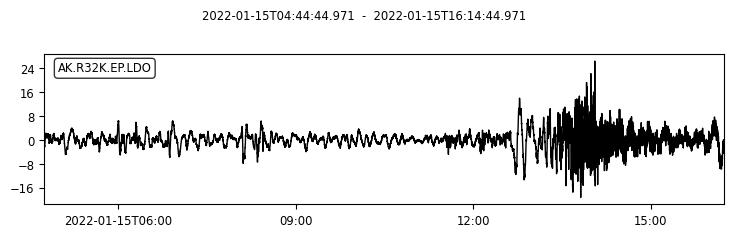

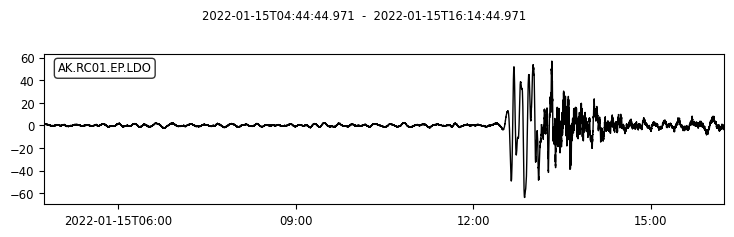

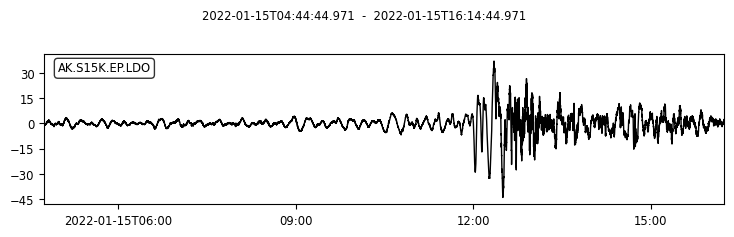

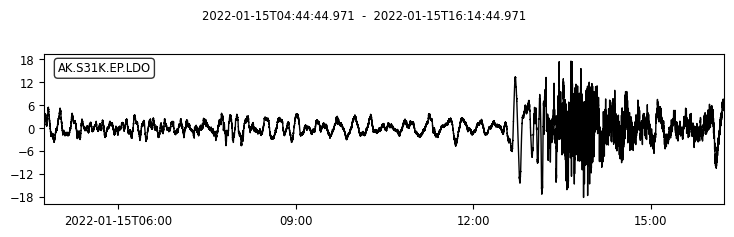

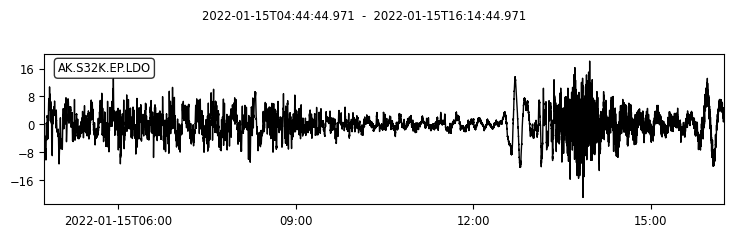

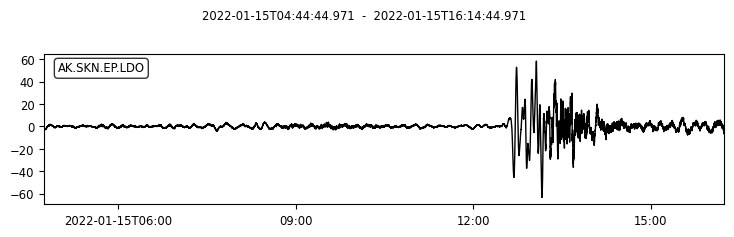

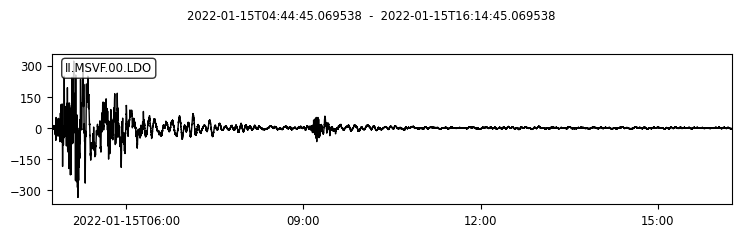

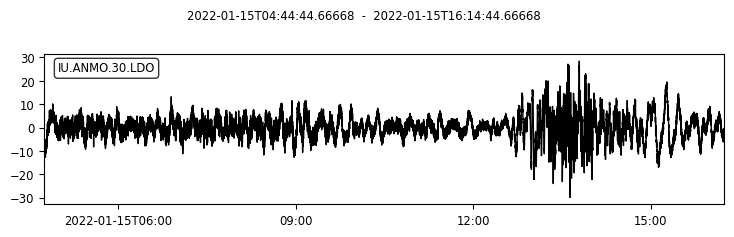

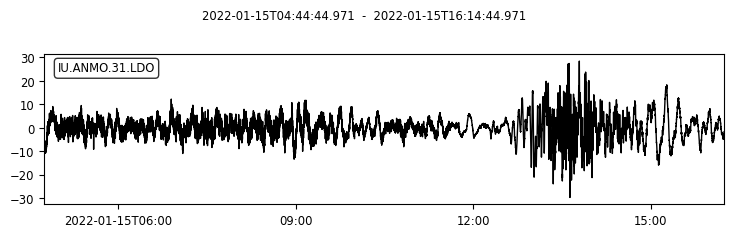

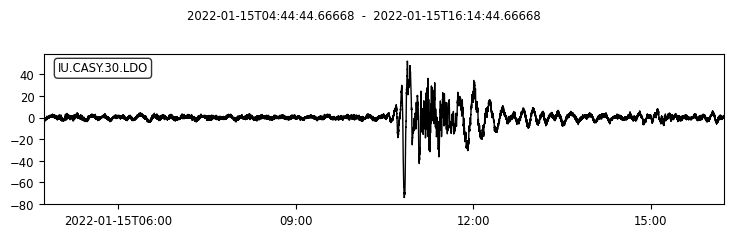

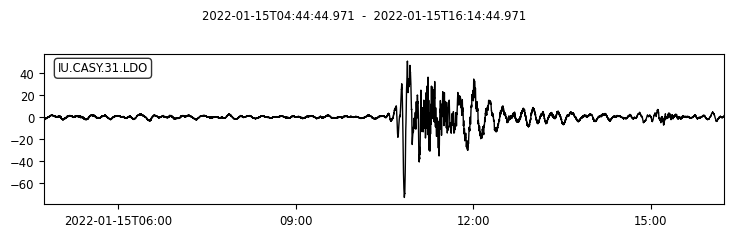

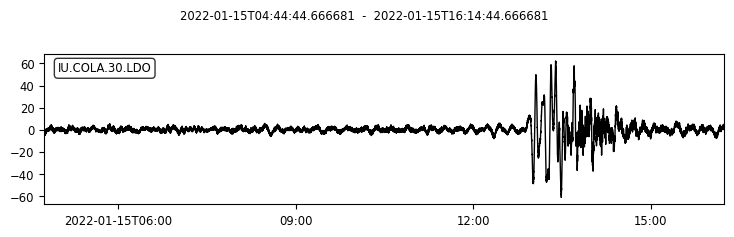

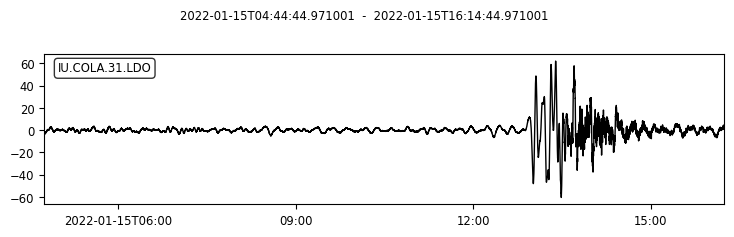

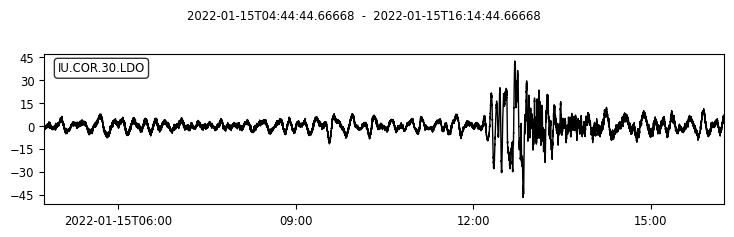

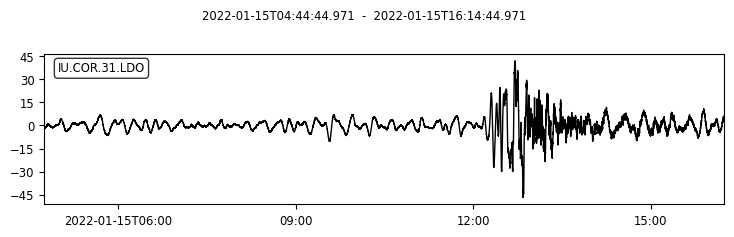

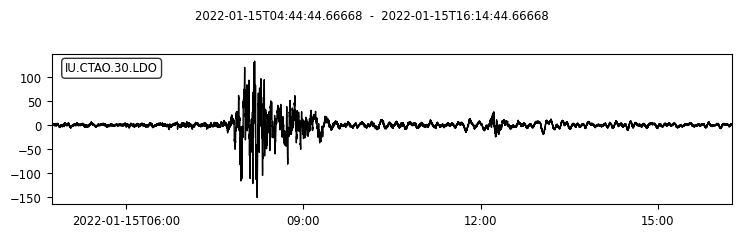

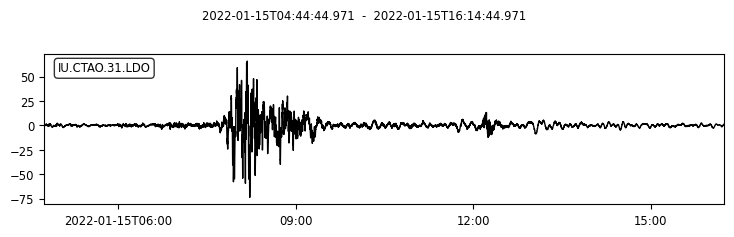

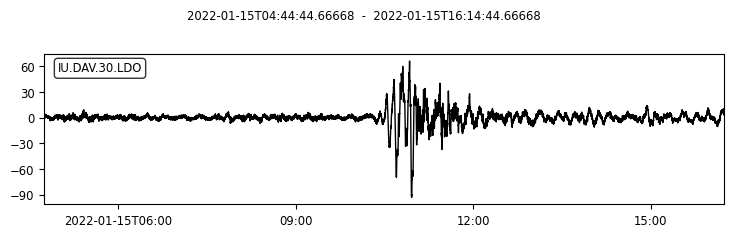

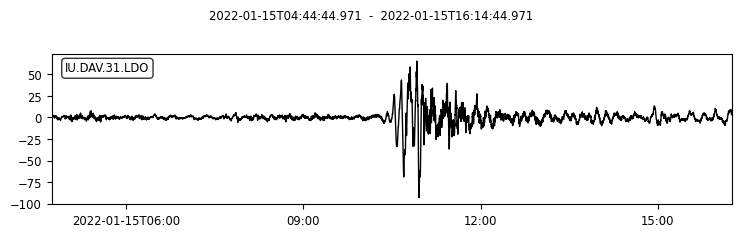

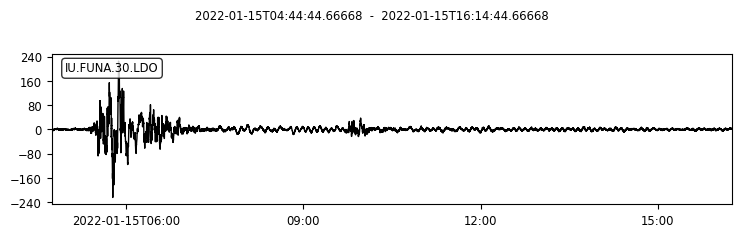

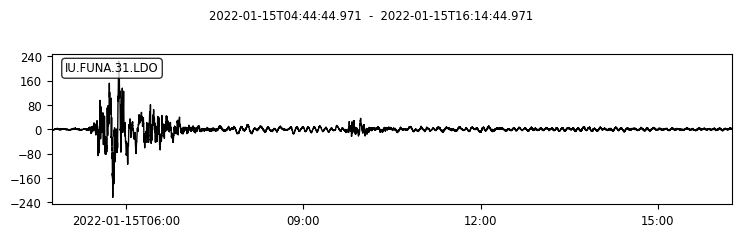

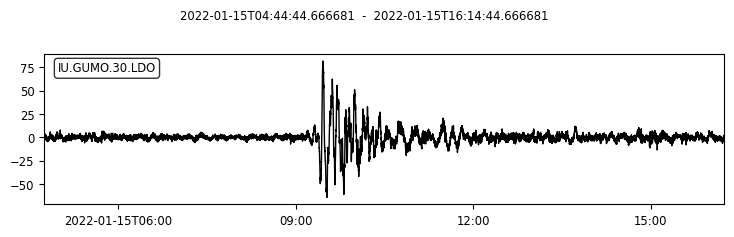

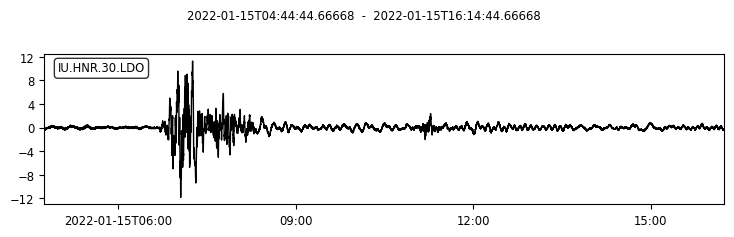

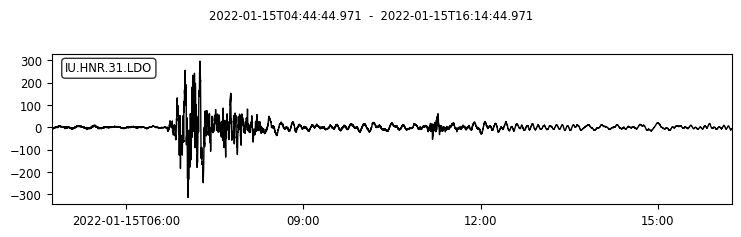

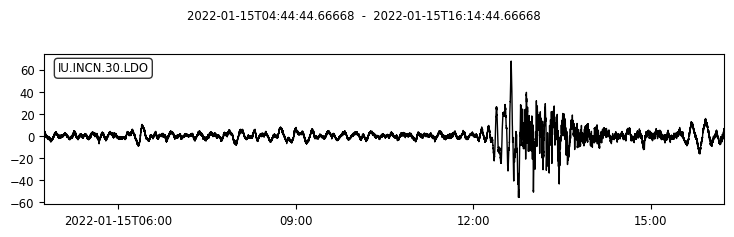

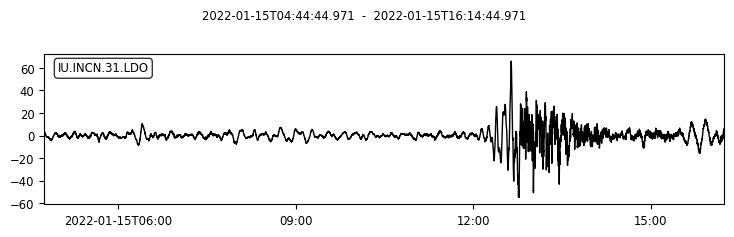

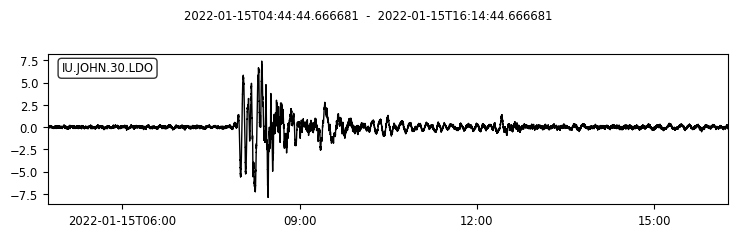

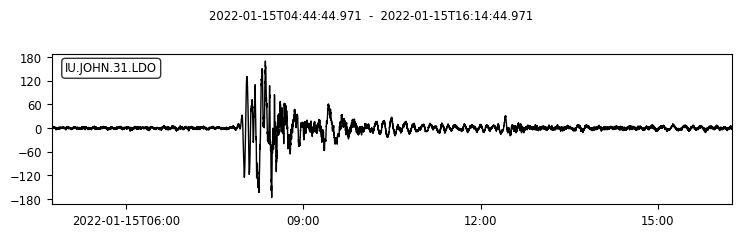

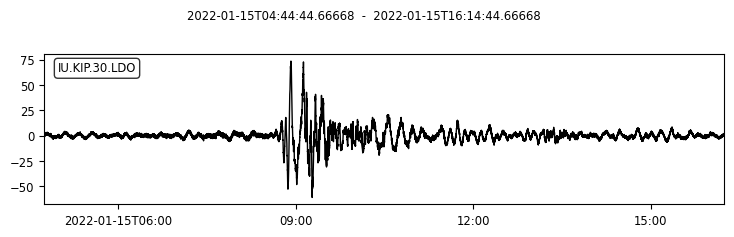

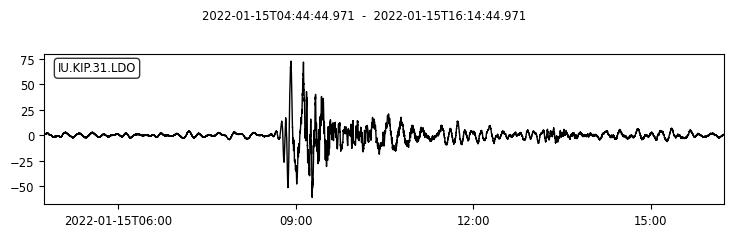

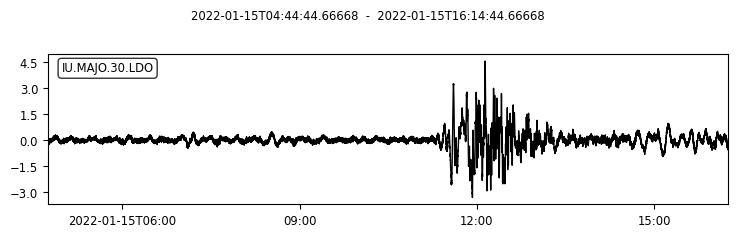

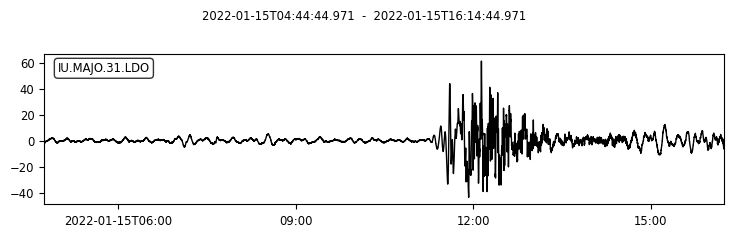

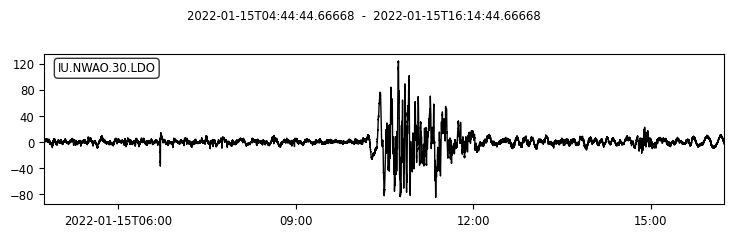

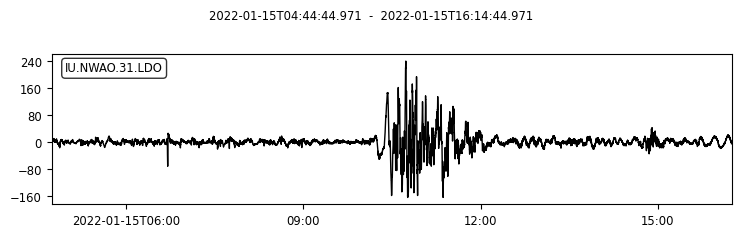

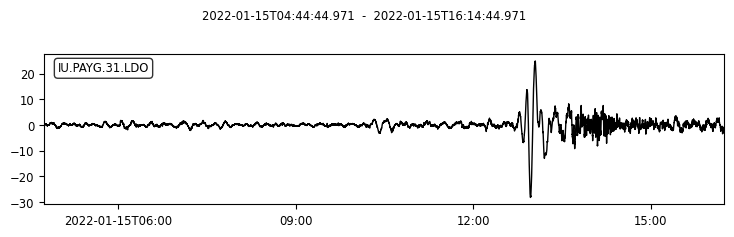

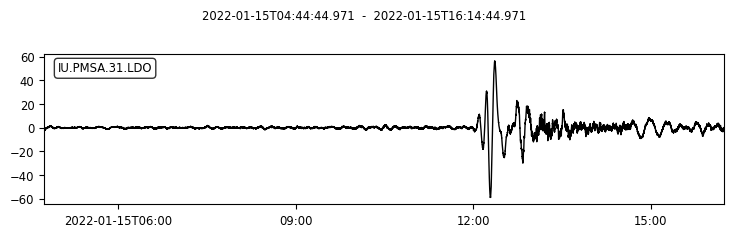

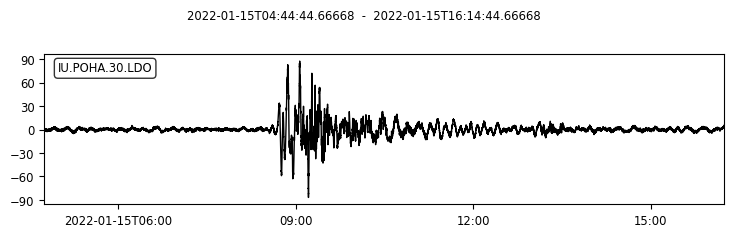

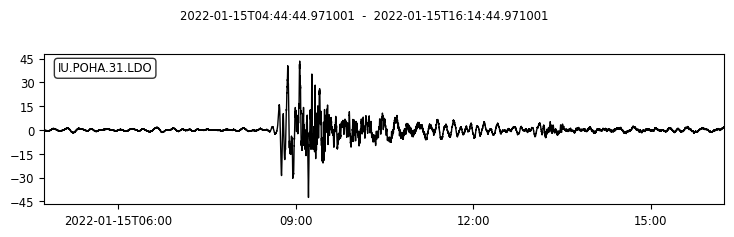

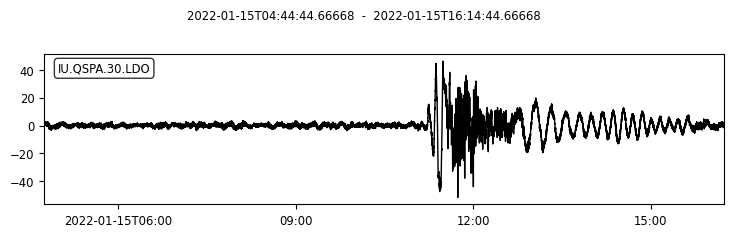

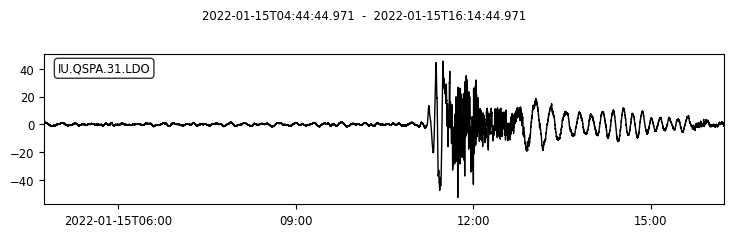

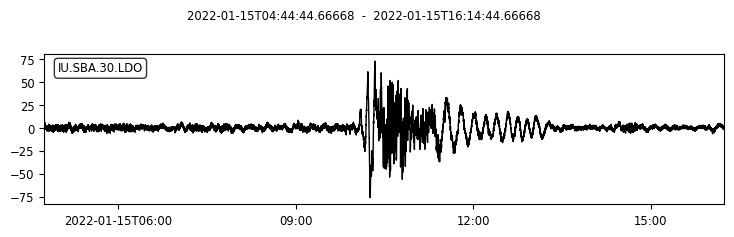

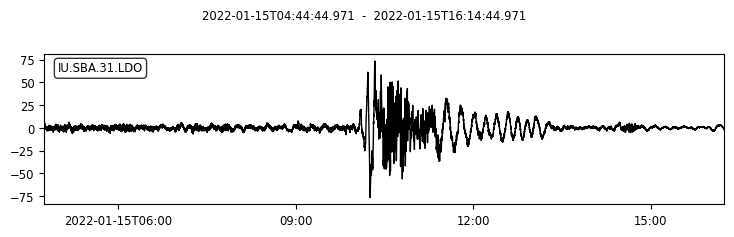

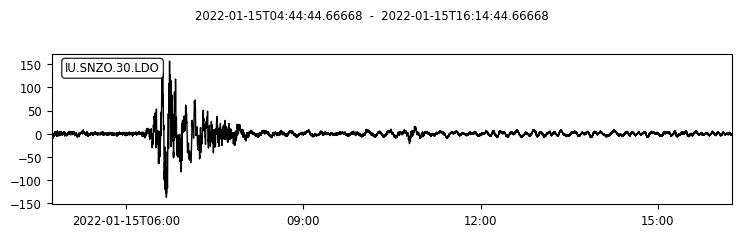

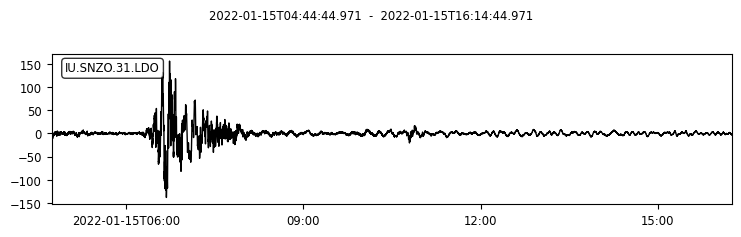

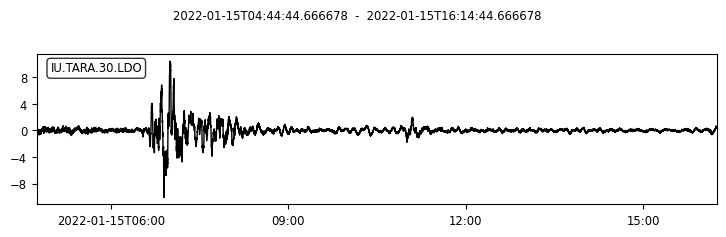

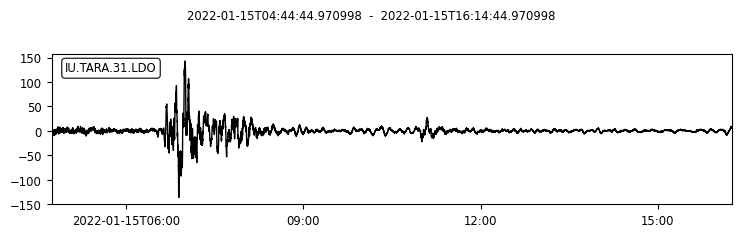

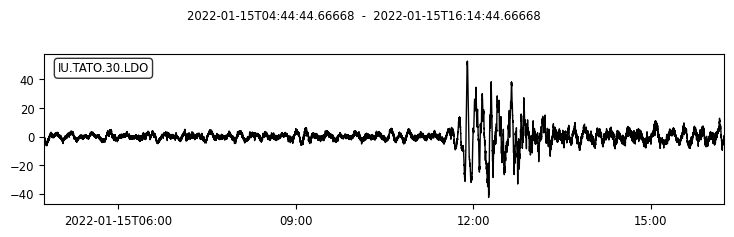

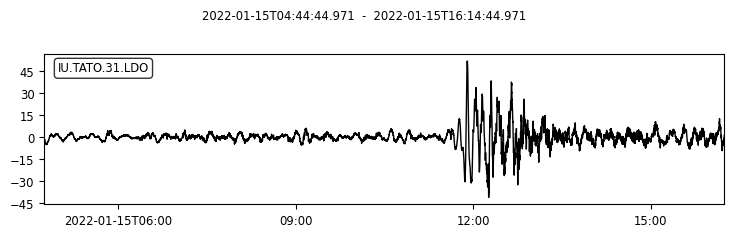

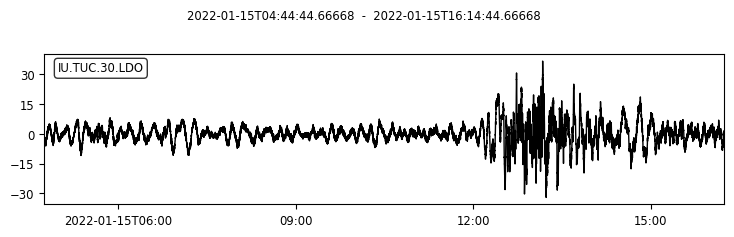

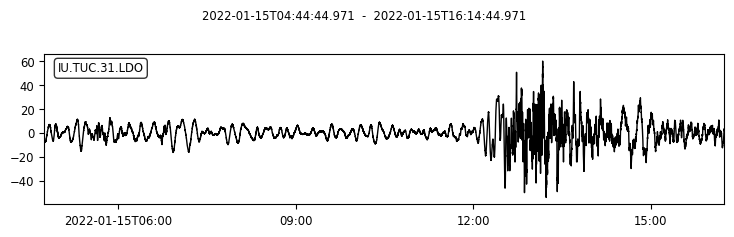

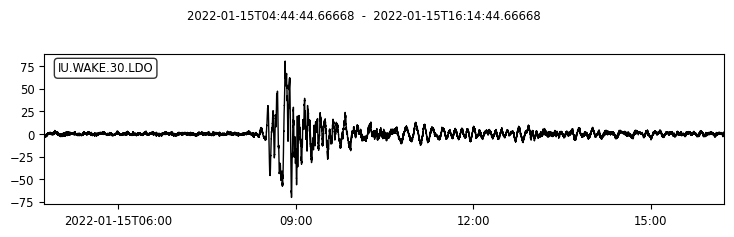

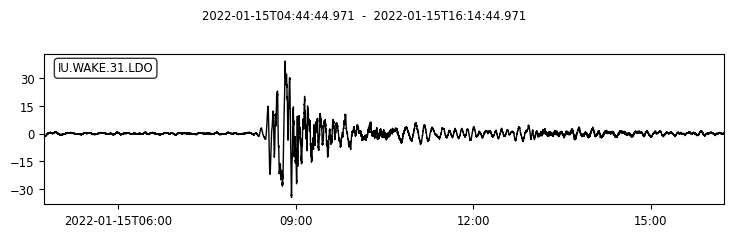

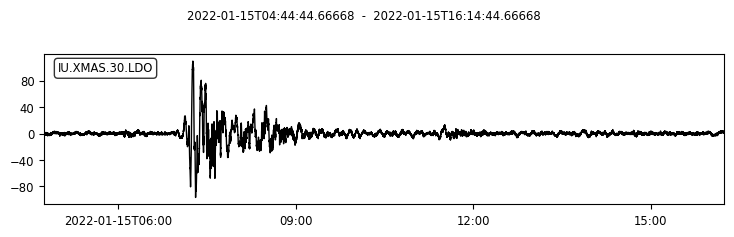

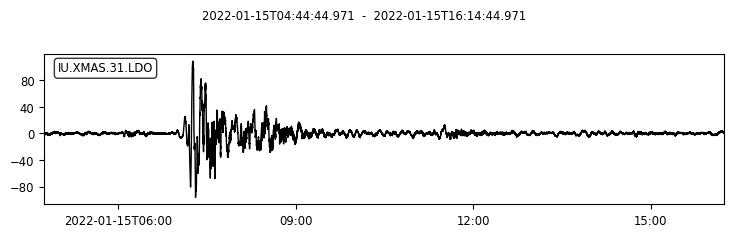

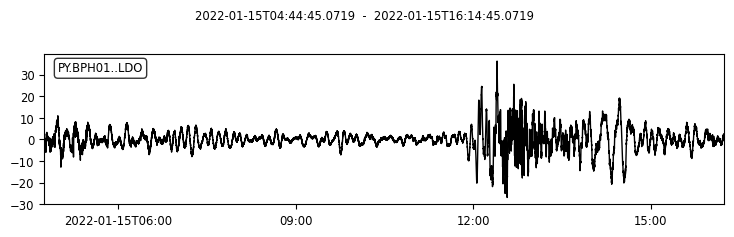

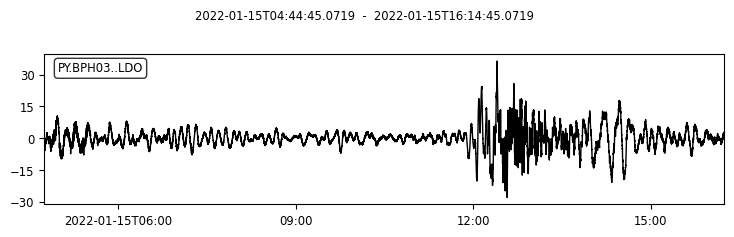

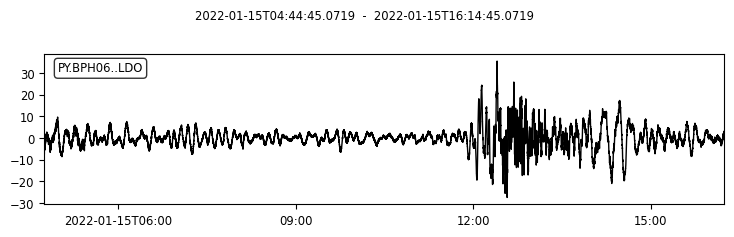

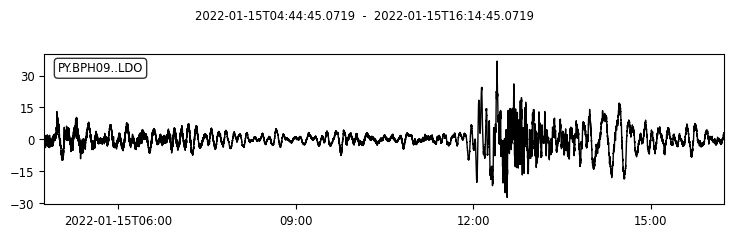

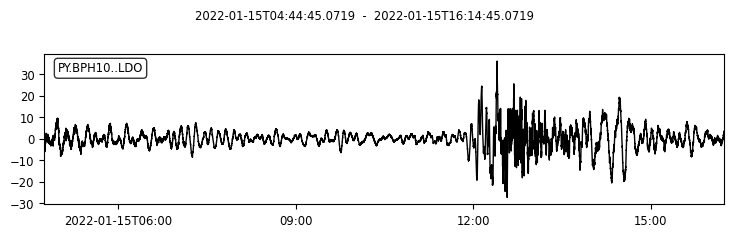

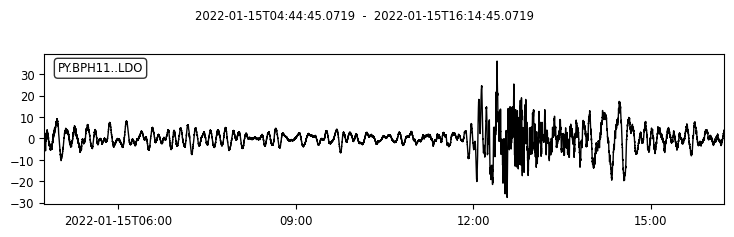

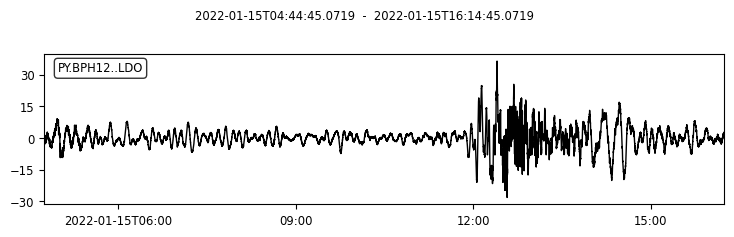

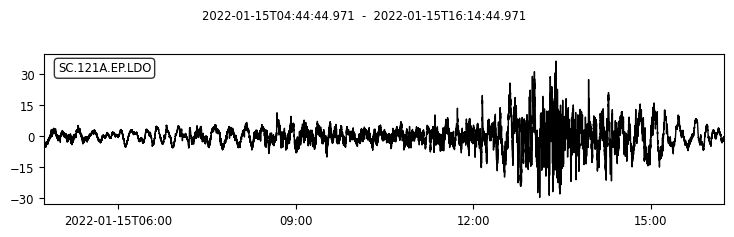

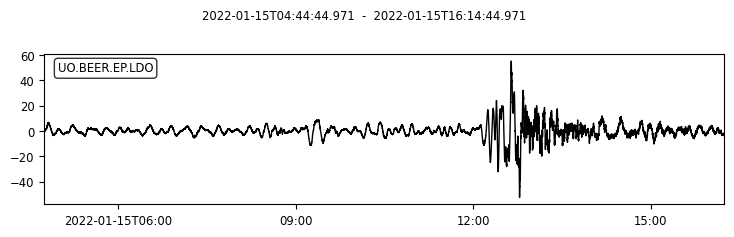

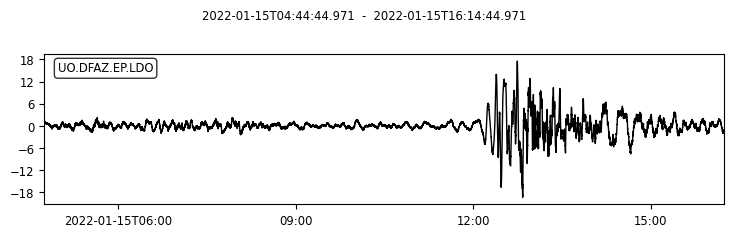

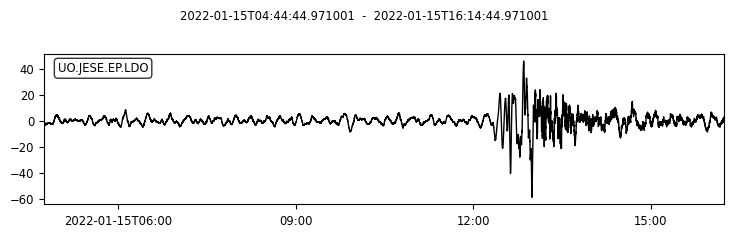

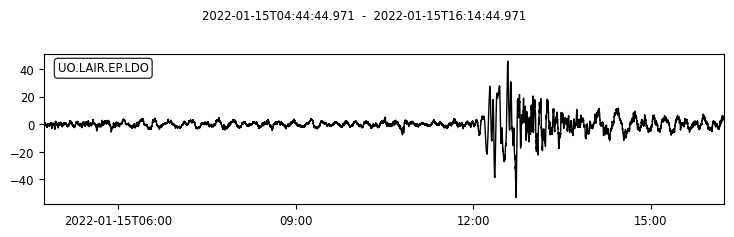

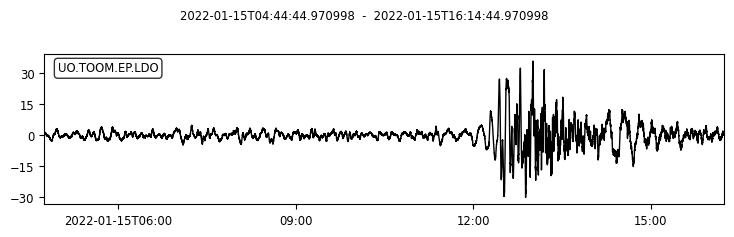

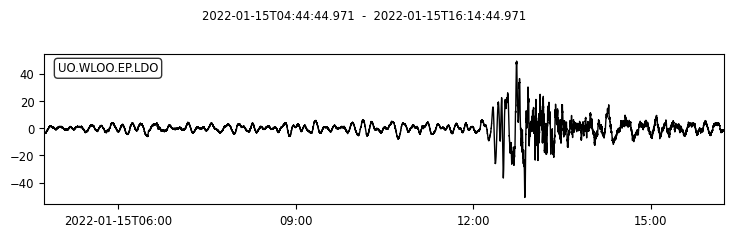

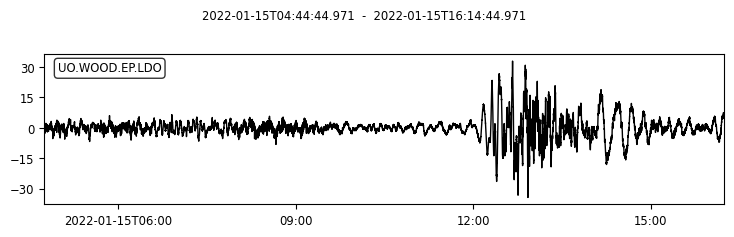

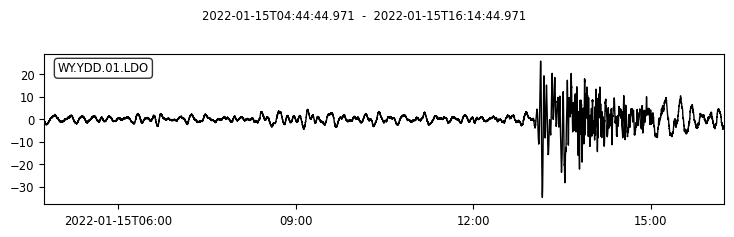

In [89]:
for tr in ldo_good:
    tr.plot()

In [90]:
# save to pickle file
import pickle
with open('good_ldo_channels_within_90_degrees.pkl', 'wb') as f:
    pickle.dump(ldo_good, f)

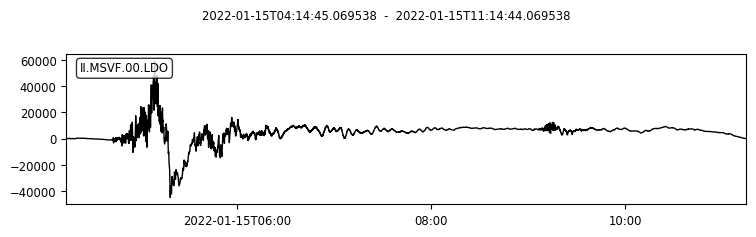

II.MSVF.00.LDO: Filtered
II.MSVF.00.LDO: calib = 69.910800


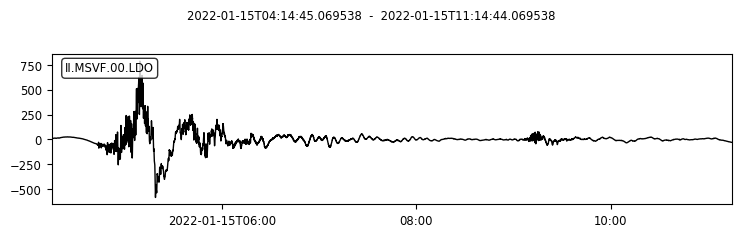

II.MSVF.00.LDO: max amp = 58999 counts before, and 787.3 units after
               network: II
               station: MSVF
              location: 00
               channel: LDO
             starttime: 2022-01-15T04:14:45.069538Z
               endtime: 2022-01-15T11:14:44.069538Z
         sampling_rate: 1.0
                 delta: 1.0
                  npts: 25200
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                filter: AttribDict({'freqmin': 0.0003, 'freqmax': 0.5, 'zerophase': True})
               history: ['padded', 'detrended', 'tapered', 'bandpass', 'unpadded']
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 12, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 49152})
       originalEndTime: 2022-01-15T11:14:44.069538Z
     originalStartTime: 2022-01-15T04:14:45.069538Z
            processing: ["ObsPy 0.0.0+archive: detrend(o

In [108]:
import numpy as np
for tr_original in st:
    tr = tr_original.copy()
    response = inv.get_response(tr.id, otime)
    try:
        calib = response.instrument_sensitivity.value 
    except:
        continue
    tr.detrend()
    tr.plot()
    maxcounts = np.max(np.abs(tr.data))
    clean_trace(tr, taperFraction=0.05, filterType="bandpass", freq=[0.0003, 0.9], \
        corners=4, zerophase=True, inv=None) 
    print('%s: Filtered' % tr.id)
    maxunits = np.max(np.abs(tr.data))
    print('%s: calib = %f' % (tr.id, calib))
    tr.data = tr.data / calib
    maxunits = np.max(np.abs(tr.data))
    tr.plot(); 
    print('%s: max amp = %.0f counts before, and %.1f Pa after' % (tr.id, maxcounts, maxunits)) 
    print(tr.stats)

In [122]:
fdsnClient = Client("IRIS")
DATA_ROOT = '/home/thompsong/DATA/Tonga202201'
searchRadiusDeg = 10.0

# location of Hunga-Tonga Hunga-Ha'apai
olat = -(20 + 34/60 + 12 /3600) 
olon = -(175 + 22/60 + 48/3600)
otime = obspy.core.UTCDateTime('2022-01-15T04:14:45.000000Z') # main eruption time - on day 2

startt = otime
endt = otime + 7 * 3600 # get 34 hours of data, since this is approximate time for sound waves to circle the earth


chanstring = 'LH?'
st, inv = get_inventory_and_waveforms(fdsnClient, searchRadiusDeg, olat, olon, startt, endt, chanstring, DATA_ROOT, overwrite=True)

/home/thompsong/DATA/Tonga202201/LH?_within_10_degrees.xml /home/thompsong/DATA/Tonga202201/LH?_within_10_degrees.mseed
Trying to load inventory from 2022/01/15 04:14 to 2022/01/15 11:14
inventory saved to /home/thompsong/DATA/Tonga202201/LH?_within_10_degrees.xml
['G.FUTU.LHE', 'G.FUTU.LHN', 'G.FUTU.LHZ', 'II.MSVF.LH1', 'II.MSVF.LH2', 'II.MSVF.LHZ', 'II.MSVF.LH1', 'II.MSVF.LH2', 'II.MSVF.LHZ', 'IU.AFI.LH1', 'IU.AFI.LH2', 'IU.AFI.LHZ', 'IU.AFI.LH1', 'IU.AFI.LH2', 'IU.AFI.LHZ', 'IU.RAO.LH1', 'IU.RAO.LH2', 'IU.RAO.LHZ', 'IU.RAO.LH1', 'IU.RAO.LH2', 'IU.RAO.LHZ']
waveform downloaded for  G.FUTU.LHE
waveform downloaded for  G.FUTU.LHN
waveform downloaded for  G.FUTU.LHZ
waveform downloaded for  II.MSVF.LH1
More than 1 Trace
waveform downloaded for  II.MSVF.LH2
More than 1 Trace
waveform downloaded for  II.MSVF.LHZ
More than 1 Trace
waveform downloaded for  II.MSVF.LH1
More than 1 Trace
waveform downloaded for  II.MSVF.LH2
More than 1 Trace
waveform downloaded for  II.MSVF.LHZ
More than 1 Tr

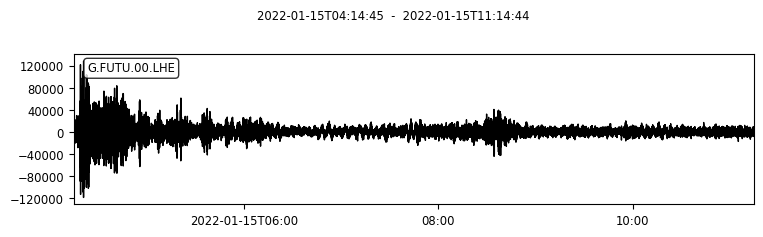

reconstituted


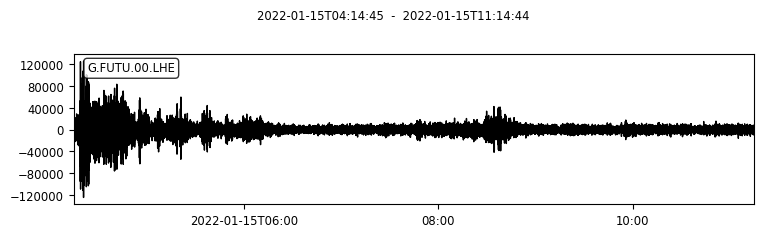

G.FUTU.00.LHE: max amp = 128450 counts before, and 6.3e-05 m/s after


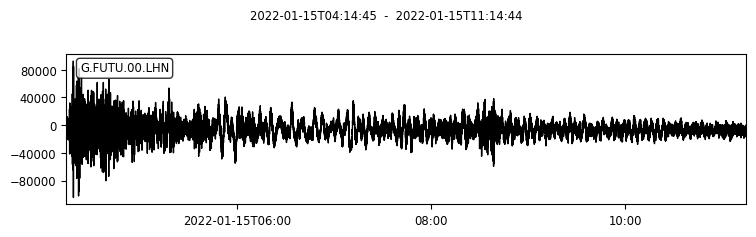

reconstituted


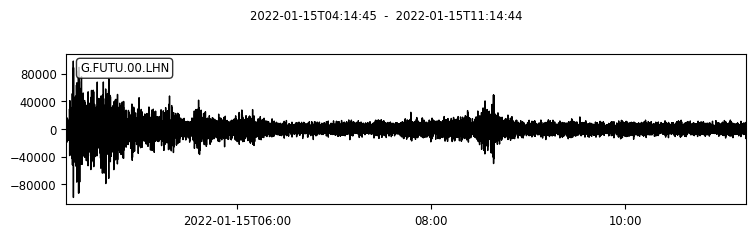

G.FUTU.00.LHN: max amp = 104443 counts before, and 4.9e-05 m/s after


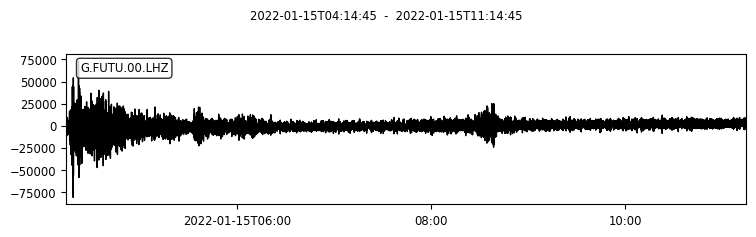

reconstituted


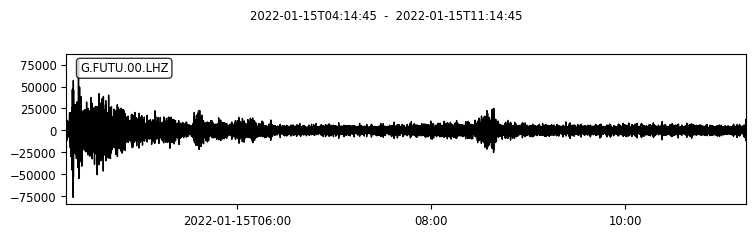

G.FUTU.00.LHZ: max amp = 81373 counts before, and 3.9e-05 m/s after


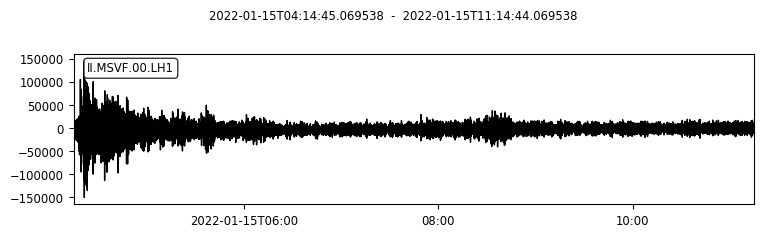

high pass filtered
II.MSVF.00.LH1: calib = 3759900000.000000 applied


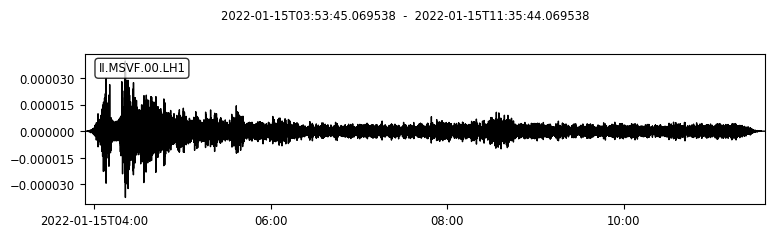

II.MSVF.00.LH1: max amp = 150541 counts before, and 4.0e-05 m/s after


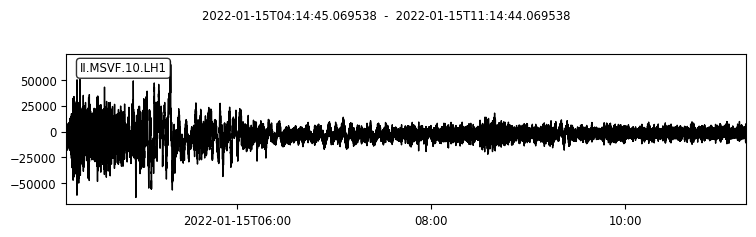

high pass filtered
II.MSVF.10.LH1: calib = 1967240000.000000 applied


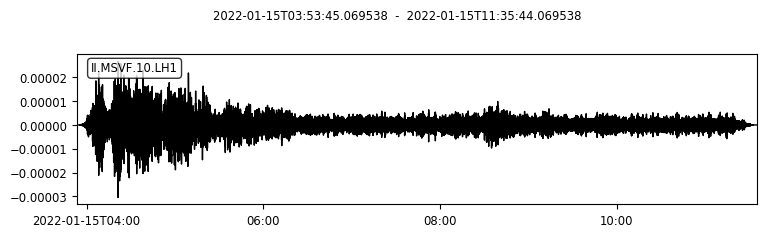

II.MSVF.10.LH1: max amp = 68219 counts before, and 3.0e-05 m/s after


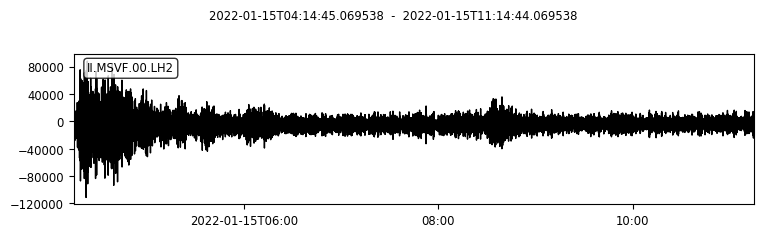

high pass filtered
II.MSVF.00.LH2: calib = 3715620000.000000 applied


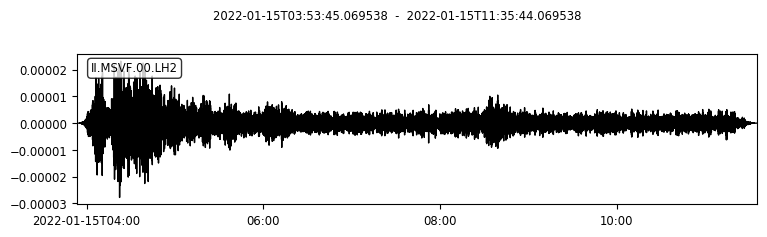

II.MSVF.00.LH2: max amp = 111227 counts before, and 2.8e-05 m/s after


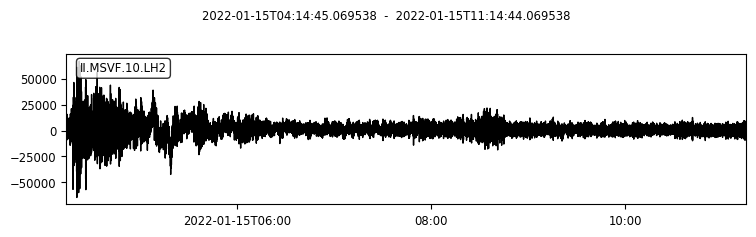

high pass filtered
II.MSVF.10.LH2: calib = 1945400000.000000 applied


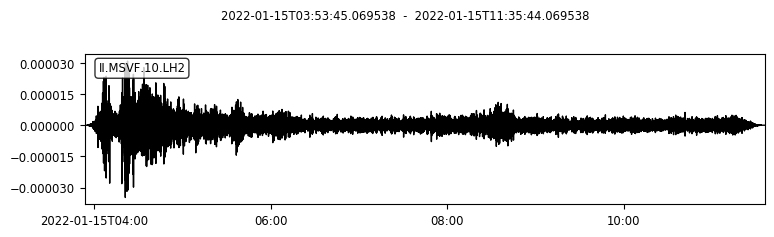

II.MSVF.10.LH2: max amp = 66838 counts before, and 3.5e-05 m/s after


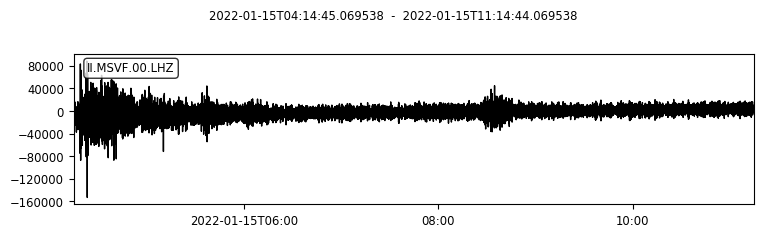

high pass filtered
II.MSVF.00.LHZ: calib = 3636040000.000000 applied


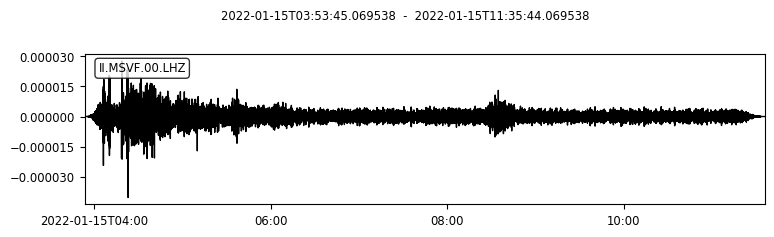

II.MSVF.00.LHZ: max amp = 153085 counts before, and 4.0e-05 m/s after


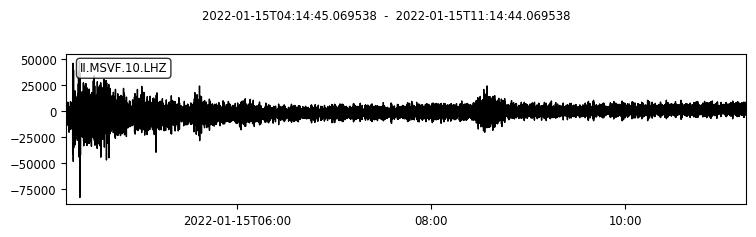

high pass filtered
II.MSVF.10.LHZ: calib = 1977160000.000000 applied


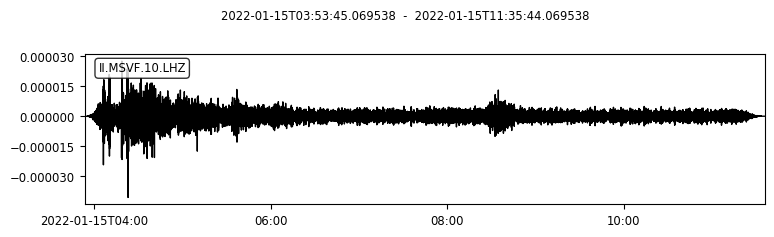

II.MSVF.10.LHZ: max amp = 83061 counts before, and 4.1e-05 m/s after


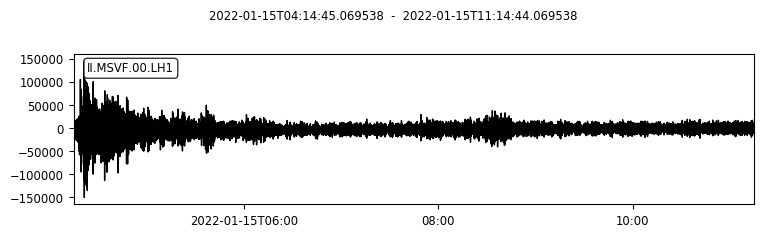

high pass filtered
II.MSVF.00.LH1: calib = 3759900000.000000 applied


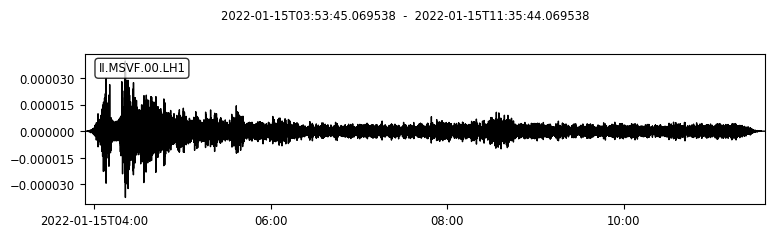

II.MSVF.00.LH1: max amp = 150541 counts before, and 4.0e-05 m/s after


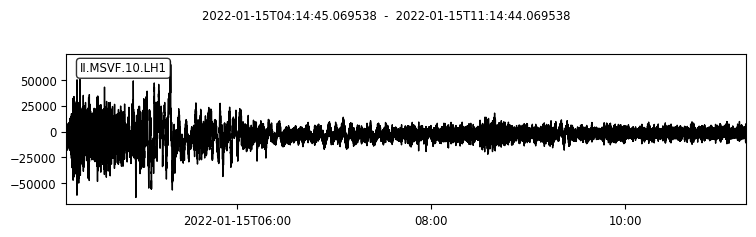

high pass filtered
II.MSVF.10.LH1: calib = 1967240000.000000 applied


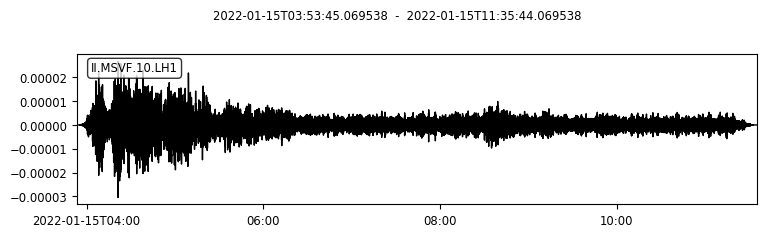

II.MSVF.10.LH1: max amp = 68219 counts before, and 3.0e-05 m/s after


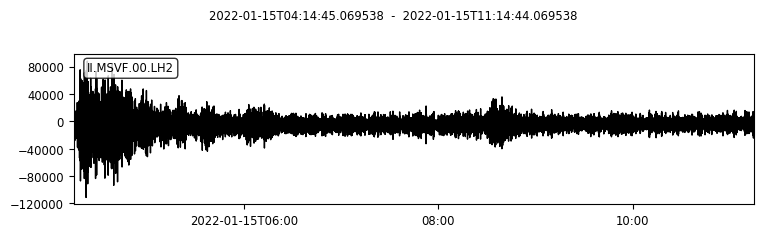

high pass filtered
II.MSVF.00.LH2: calib = 3715620000.000000 applied


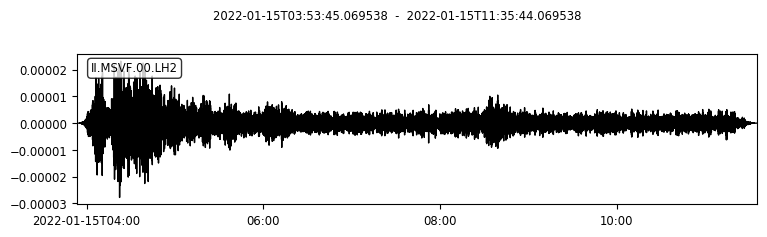

II.MSVF.00.LH2: max amp = 111227 counts before, and 2.8e-05 m/s after


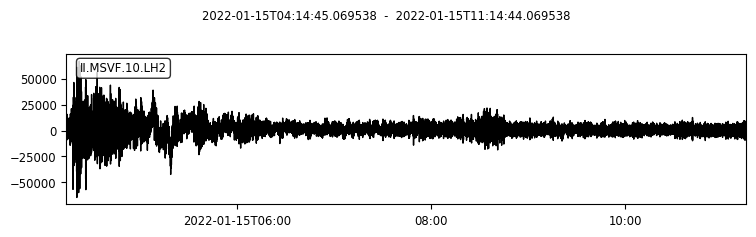

high pass filtered
II.MSVF.10.LH2: calib = 1945400000.000000 applied


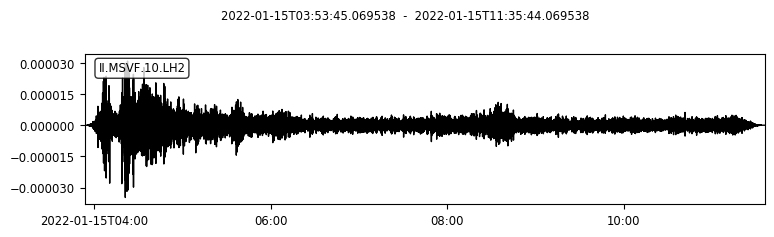

II.MSVF.10.LH2: max amp = 66838 counts before, and 3.5e-05 m/s after


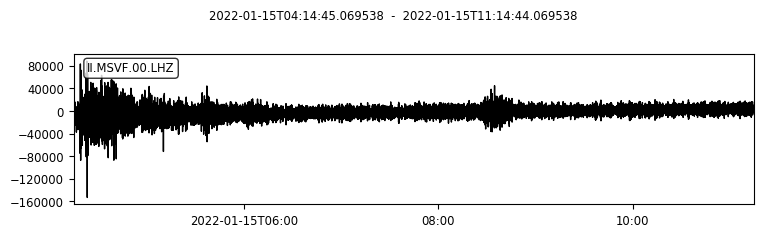

high pass filtered
II.MSVF.00.LHZ: calib = 3636040000.000000 applied


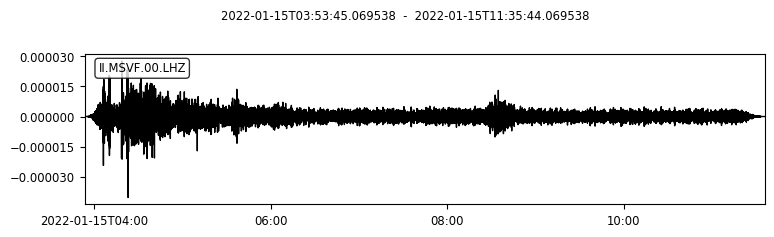

II.MSVF.00.LHZ: max amp = 153085 counts before, and 4.0e-05 m/s after


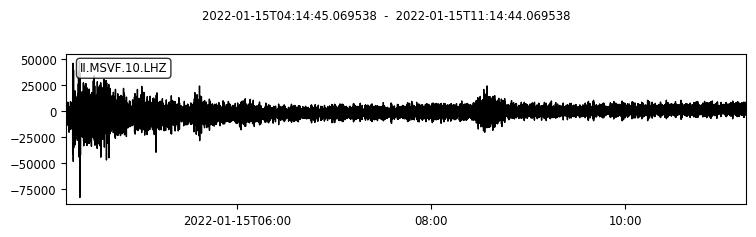

high pass filtered
II.MSVF.10.LHZ: calib = 1977160000.000000 applied


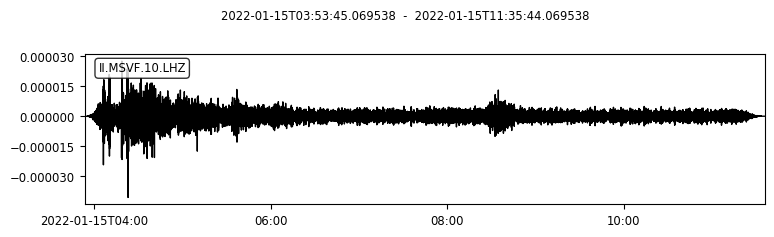

II.MSVF.10.LHZ: max amp = 83061 counts before, and 4.1e-05 m/s after


In [129]:
import numpy as np
freq = [0.01, 0.9]
for tr_original in st:
    tr = tr_original.copy()
    tr.detrend()
    tr.plot()
    maxcounts = np.max(np.abs(tr.data))
    try:
        clean_trace(tr, taperFraction=0.05, filterType="bandpass", freq=freq, \
            corners=4, zerophase=True, inv=inv)
        print('reconstituted')
    except:
        clean_trace(tr, taperFraction=0.05, filterType="bandpass", freq=freq, \
            corners=4, zerophase=True, inv=None)   
        print('high pass filtered')
        response = inv.get_response(tr.id, otime)
        calib = response.instrument_sensitivity.value
        print('%s: calib = %f applied' % (tr.id, calib))
        #tr.data = tr.data / calib
    maxunits = np.max(np.abs(tr.data))
    tr.plot(); 
    print('%s: max amp = %.0f counts before, and %.1e m/s after' % (tr.id, maxcounts, maxunits)) 
    #print(tr.stats)

II.MSVF.00.LDI, 9.3e+05, 3.1e+03, 0.0e+00
II.MSVF.00.LDO, 8.7e+05, 2.2e+04, 3.1e+02
II.MSVF.00.LH1, 1.5e+05, 1.5e+05, 0.0e+00
II.MSVF.00.LH2, 1.1e+05, 1.1e+05, 0.0e+00
II.MSVF.00.LHZ, 1.5e+05, 1.5e+05, 0.0e+00
II.MSVF.10.LH1, 5.9e+04, 5.7e+04, 0.0e+00
II.MSVF.10.LH2, 6.7e+04, 6.6e+04, 0.0e+00
II.MSVF.10.LHZ, 7.9e+04, 7.9e+04, 0.0e+00


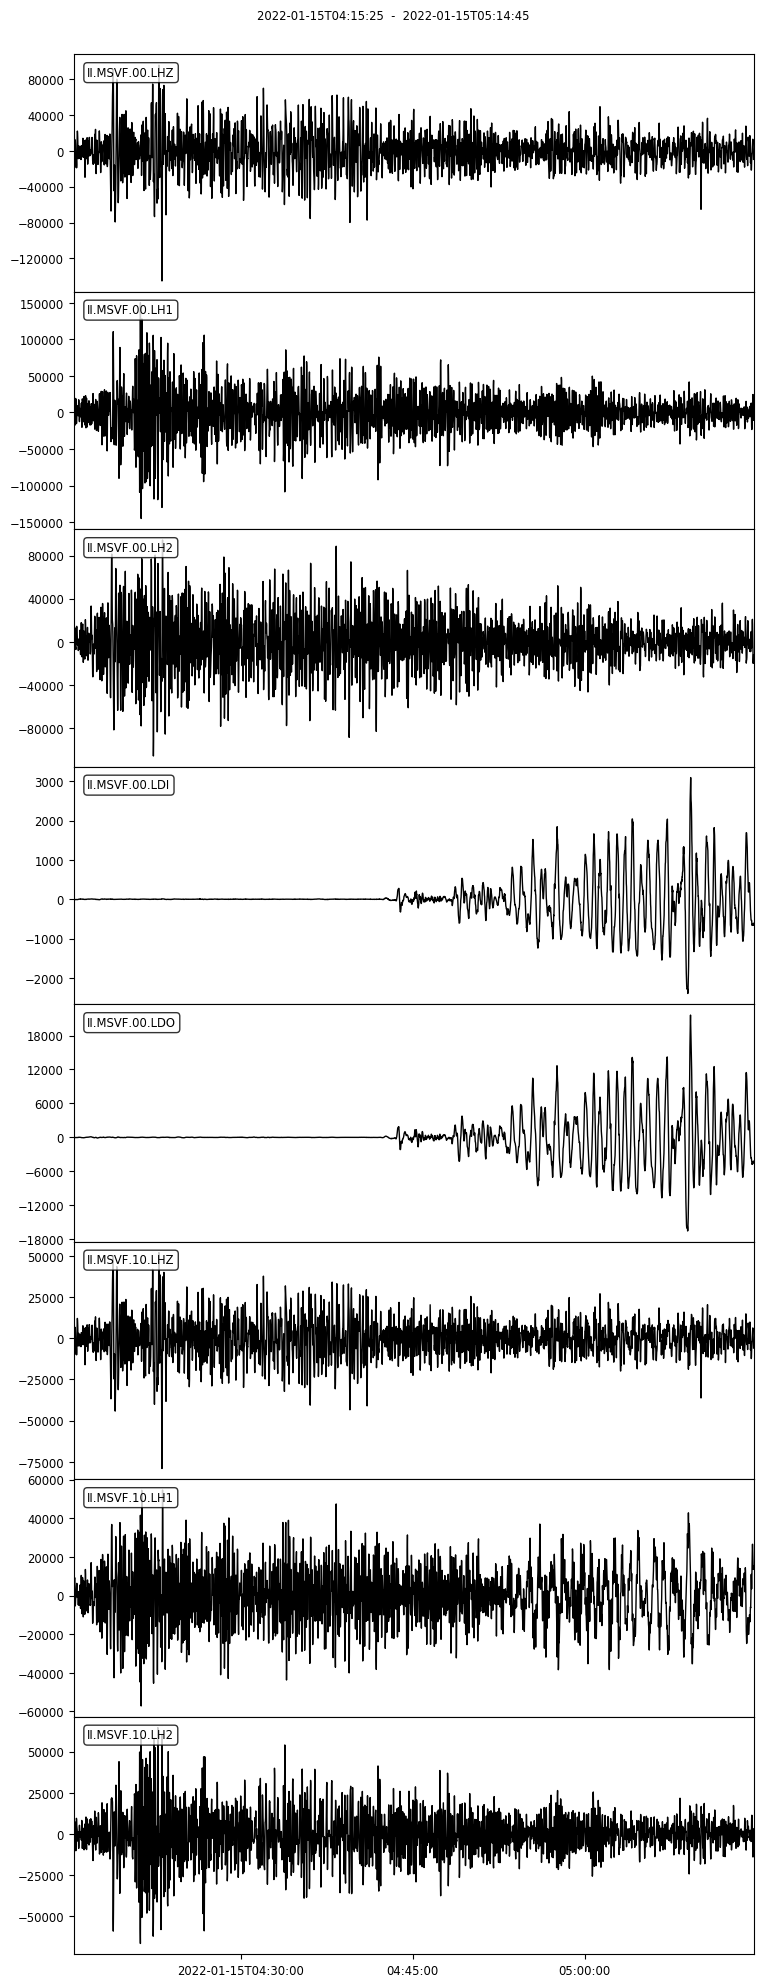

In [121]:
stiris = obspy.core.read(os.path.join(DATA_ROOT, 'MINISEED', '2022-01-15-ms_2058-tonga-islands.miniseed'))

msvf=stiris.select(station='MSVF')

#print(msvf)

for tr in msvf:
    #print(tr)
    maxcounts = np.max(np.abs(tr.data))
    clean_trace(tr, taperFraction=0.05, filterType="highpass", freq=0.01, \
        corners=4, zerophase=True, inv=None) 
    maxfiltered = np.max(np.abs(tr.data))
    try:
        response = inv.get_response(tr.id, otime)
        calib = response.instrument_sensitivity.value
        maxunits = np.max(np.abs(tr.data/calib))
    except:
        maxunits = 0
    print("%s, %.1e, %.1e, %.1e" % (tr.id, maxcounts, maxfiltered, maxunits))

msvf.plot(equal_scale=False);

In [137]:
fdsnClient = Client("IRIS")
DATA_ROOT = os.path.join(os.getenv('HOME'), 'DATA', 'Tonga202201')
searchRadiusDeg = 90.0

# location of Hunga-Tonga Hunga-Ha'apai
olat = -(20 + 34/60 + 12 /3600) 
olon = -(175 + 22/60 + 48/3600)
otime = obspy.core.UTCDateTime('2022-01-15T04:14:45.000000Z') # main eruption time - on day 2

startt = otime
endt = otime + 34 * 3600 # get 34 hours of data, since this is approximate time for sound waves to circle the earth


chanstring = 'LDF'
st, inv = get_inventory_and_waveforms(fdsnClient, searchRadiusDeg, olat, olon, startt, endt, chanstring, DATA_ROOT, overwrite=True)

/home/thompsong/DATA/Tonga202201/LDF_within_90_degrees.xml /home/thompsong/DATA/Tonga202201/LDF_within_90_degrees.mseed
Trying to load inventory from 2022/01/15 04:14 to 2022/01/16 14:14
inventory saved to /home/thompsong/DATA/Tonga202201/LDF_within_90_degrees.xml
['AE.214A.LDF', 'AK.C16K.LDF', 'AK.C18K.LDF', 'AK.CAPN.LDF', 'AK.CHUM.LDF', 'AK.COLD.LDF', 'AK.CUT.LDF', 'AK.D17K.LDF', 'AK.E18K.LDF', 'AK.E19K.LDF', 'AK.F15K.LDF', 'AK.F18K.LDF', 'AK.F20K.LDF', 'AK.F21K.LDF', 'AK.G17K.LDF', 'AK.G19K.LDF', 'AK.G23K.LDF', 'AK.G24K.LDF', 'AK.H16K.LDF', 'AK.H17K.LDF', 'AK.H20K.LDF', 'AK.H21K.LDF', 'AK.H22K.LDF', 'AK.H23K.LDF', 'AK.H24K.LDF', 'AK.HARP.LDF', 'AK.HDA.LDF', 'AK.HOM.LDF', 'AK.I21K.LDF', 'AK.I23K.LDF', 'AK.I26K.LDF', 'AK.I27K.LDF', 'AK.J17K.LDF', 'AK.J19K.LDF', 'AK.J20K.LDF', 'AK.J25K.LDF', 'AK.J26L.LDF', 'AK.K13K.LDF', 'AK.K15K.LDF', 'AK.K20K.LDF', 'AK.K24K.LDF', 'AK.K27K.LDF', 'AK.L14K.LDF', 'AK.L16K.LDF', 'AK.L17K.LDF', 'AK.L18K.LDF', 'AK.L19K.LDF', 'AK.L20K.LDF', 'AK.L22K.LDF', 'A

reconstituted
AK.CAPN.EP.LDF: max amp = 116271 counts before, and 4.1e+00 units after
reconstituted
AK.CHUM.EP.LDF: max amp = 1283344 counts before, and 4.3e+01 units after
reconstituted
AK.COLD.EP.LDF: max amp = 1463252 counts before, and 3.9e+01 units after
reconstituted
AK.CUT.EP.LDF: max amp = 1707830 counts before, and 6.3e+01 units after
reconstituted
AK.D17K.EP.LDF: max amp = 4708155 counts before, and 5.5e+01 units after
reconstituted
AK.F15K.EP.LDF: max amp = 3938031 counts before, and 5.8e+01 units after
reconstituted
AK.F18K.EP.LDF: max amp = 2075652 counts before, and 3.7e+01 units after
reconstituted
AK.G17K.EP.LDF: max amp = 1508526 counts before, and 3.3e+01 units after
reconstituted
AK.G19K.EP.LDF: max amp = 1476748 counts before, and 3.5e+01 units after
reconstituted
AK.G24K.EP.LDF: max amp = 2411126 counts before, and 6.6e+01 units after
reconstituted
AK.H16K.EP.LDF: max amp = 2399356 counts before, and 4.2e+01 units after
reconstituted
AK.H17K.EP.LDF: max amp = 20199

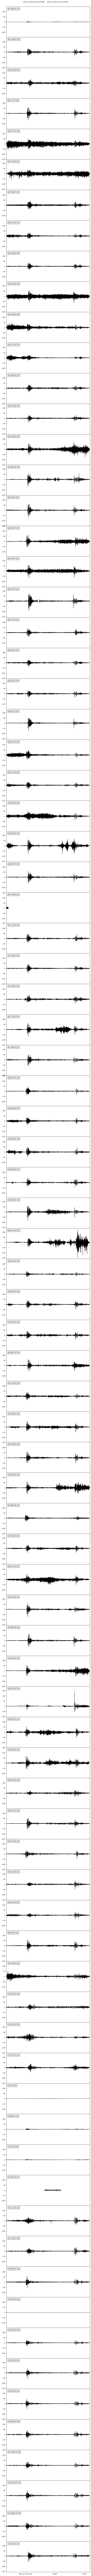

In [147]:
import numpy as np
freq = [0.001, 0.9]
st2 = obspy.core.Stream()
for tr_original in st:
    tr = tr_original.copy()
    st2 = st2.append(tr)
    try:
        st2.merge(method=1, fill_value=0)
    except:
        st2.remove(tr)
        pass
st_good = obspy.core.Stream()
for tr_original in st2:
    tr = tr_original.copy()
    n = np.count_nonzero(tr.data==0)
    if n/len(tr.data) > 0.1:
        st2.remove(tr_original)
        continue
    tr.detrend()
    maxcounts = np.max(np.abs(tr.data))
    tr.filter("highpass", freq=freq[0])
    try:
        tr.remove_response(inventory=inv)
        print('reconstituted')
        st_good.append(tr)
    except:
        pass
    maxunits = np.max(np.abs(tr.data))
    print('%s: max amp = %.0f counts before, and %.1e units after' % (tr.id, maxcounts, maxunits)) 

st_good.plot(equal_scale=True);

In [102]:
# ok. next let us try to examine other blasts. and expand to looking at infrasound stations within 50 degrees.